## Peak Demand Forecasting
- LSTM Neural Networks for capturing temporal dependencies
- Gradient Boosting Models for handling non-linear relationships
- Probabilistic Forecasting for quantifying uncertainty

*Models are combined into an ensemble to improve accuracy*

### Model Output, TL;DR

<p><em>Actual v Predicted Demand - One Week Detail</em></p>

<img src='./Desktop/Energy Demand Sim/Actual v Predicted Demand - One Week Detail.png' alt='Actual v Predicted Demand - One Week Detail.png' width='800'>

<p><em>Actual v Predicted Demand</em></p>

<img src='./Desktop/Energy Demand Sim/Actual v Predicted Demand.png' alt='Actual v Predicted Demand.png' width='800'>

<p><em>Energy Demand</em></p>

<img src='./Desktop/Energy Demand Sim/Energy Demand.png' alt='Energy Demand.png' width='800'>

<p><em>Forecast and Exceedence</em></p>

<img src='./Desktop/Energy Demand Sim/Forecast and Exceedence.png' alt='Forecast and Exceedence.png' width='800'>

<p><em>LTSM Model Loss</em></p>

<img src='./Desktop/Energy Demand Sim/LTSM Model Loss.png' alt='LTSM Model Loss.png' width='800'>

<p><em>Peak Event Detection</em></p>

<img src='./Desktop/Energy Demand Sim/Peak Event Detection.png' alt='Peak Event Detection.png' width='800'>

<p><em>Probabilistic Demand Forecast - One Week Detail</em></p>

<img src='./Desktop/Energy Demand Sim/Probabilistic Demand Forecast - One Week Detail.png' alt='Probabilistic Demand Forecast - One Week Detail.png' width='800'>

<p><em>Probabilistic Demand Forecast</em></p>

<img src='./Desktop/Energy Demand Sim/Probabilistic Demand Forecast.png' alt='Probabilistic Demand Forecast.png' width='800'>

<p><em>Summary</em></p>

<img src='./Desktop/Energy Demand Sim/Summary.png' alt='Summary.png' width='800'>

### Setup and Dependencies

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('./Desktop/gruvbox.mplstyle')
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)

print("Setup complete!")

Setup complete!


#### 2. Data Loading

In [2]:
data_path = os.path.expanduser("~/Downloads/complete_dataset.csv")
print(f"Loading data from: {data_path}")

# Check if the file exists
if os.path.exists(data_path):
    print("File found, loading data...")
    df = pd.read_csv(data_path)
    print("Data loaded successfully!")
else:
    print(f"Error: File not found at {data_path}")

# Basic Info
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
df.describe()

df.head()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])
df.head(5)


Loading data from: /Users/rohandaggubati/Downloads/complete_dataset.csv
File found, loading data...
Data loaded successfully!
Dataset shape: (2106, 14)

Data types:
date                object
demand             float64
RRP                float64
demand_pos_RRP     float64
RRP_positive       float64
demand_neg_RRP     float64
RRP_negative       float64
frac_at_neg_RRP    float64
min_temperature    float64
max_temperature    float64
solar_exposure     float64
rainfall           float64
school_day          object
holiday             object
dtype: object

Summary statistics:
Missing values per column:
solar_exposure    1
rainfall          3
dtype: int64


date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  25.633696       97319.240     26.415953   
1  2015-01-02  129606.010  33.138988      121082.015     38.837661   
2  2015-01-03  142300.540  34.564855      142300.540     34.564855   
3  2015-01-04  104330.715  25.005560      104330.715     25.005560   
4  2015-01-05  118132.200  26.724176      118132.200     26.724176   

   demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0        2315.790     -7.240000         0.020833             13.3   
1        8523.995    -47.809777         0.062500             15.4   
2           0.000      0.000000         0.000000             20.0   
3           0.000      0.000000         0.000000             16.3   
4           0.000      0.000000         0.000000             15.0   

   max_temperature  solar_exposure  rainfall school_day holiday  
0             26.9            23.6       0.0          N       Y  
1             38.8            26.8       0.0          N       N  
2             38.2            26.5       0.0          N       N  
3             21.4            25.2       4.2          N       N  
4             22.0            30.7       0.0          N       N

#### 3. Data Preprocessing

Using 'date' as the timestamp column
Converted 'date' to datetime
Using 'demand' as the demand column
Set timestamp as index and sorted data
Data time frequency appears to be: 1 days 00:00:00


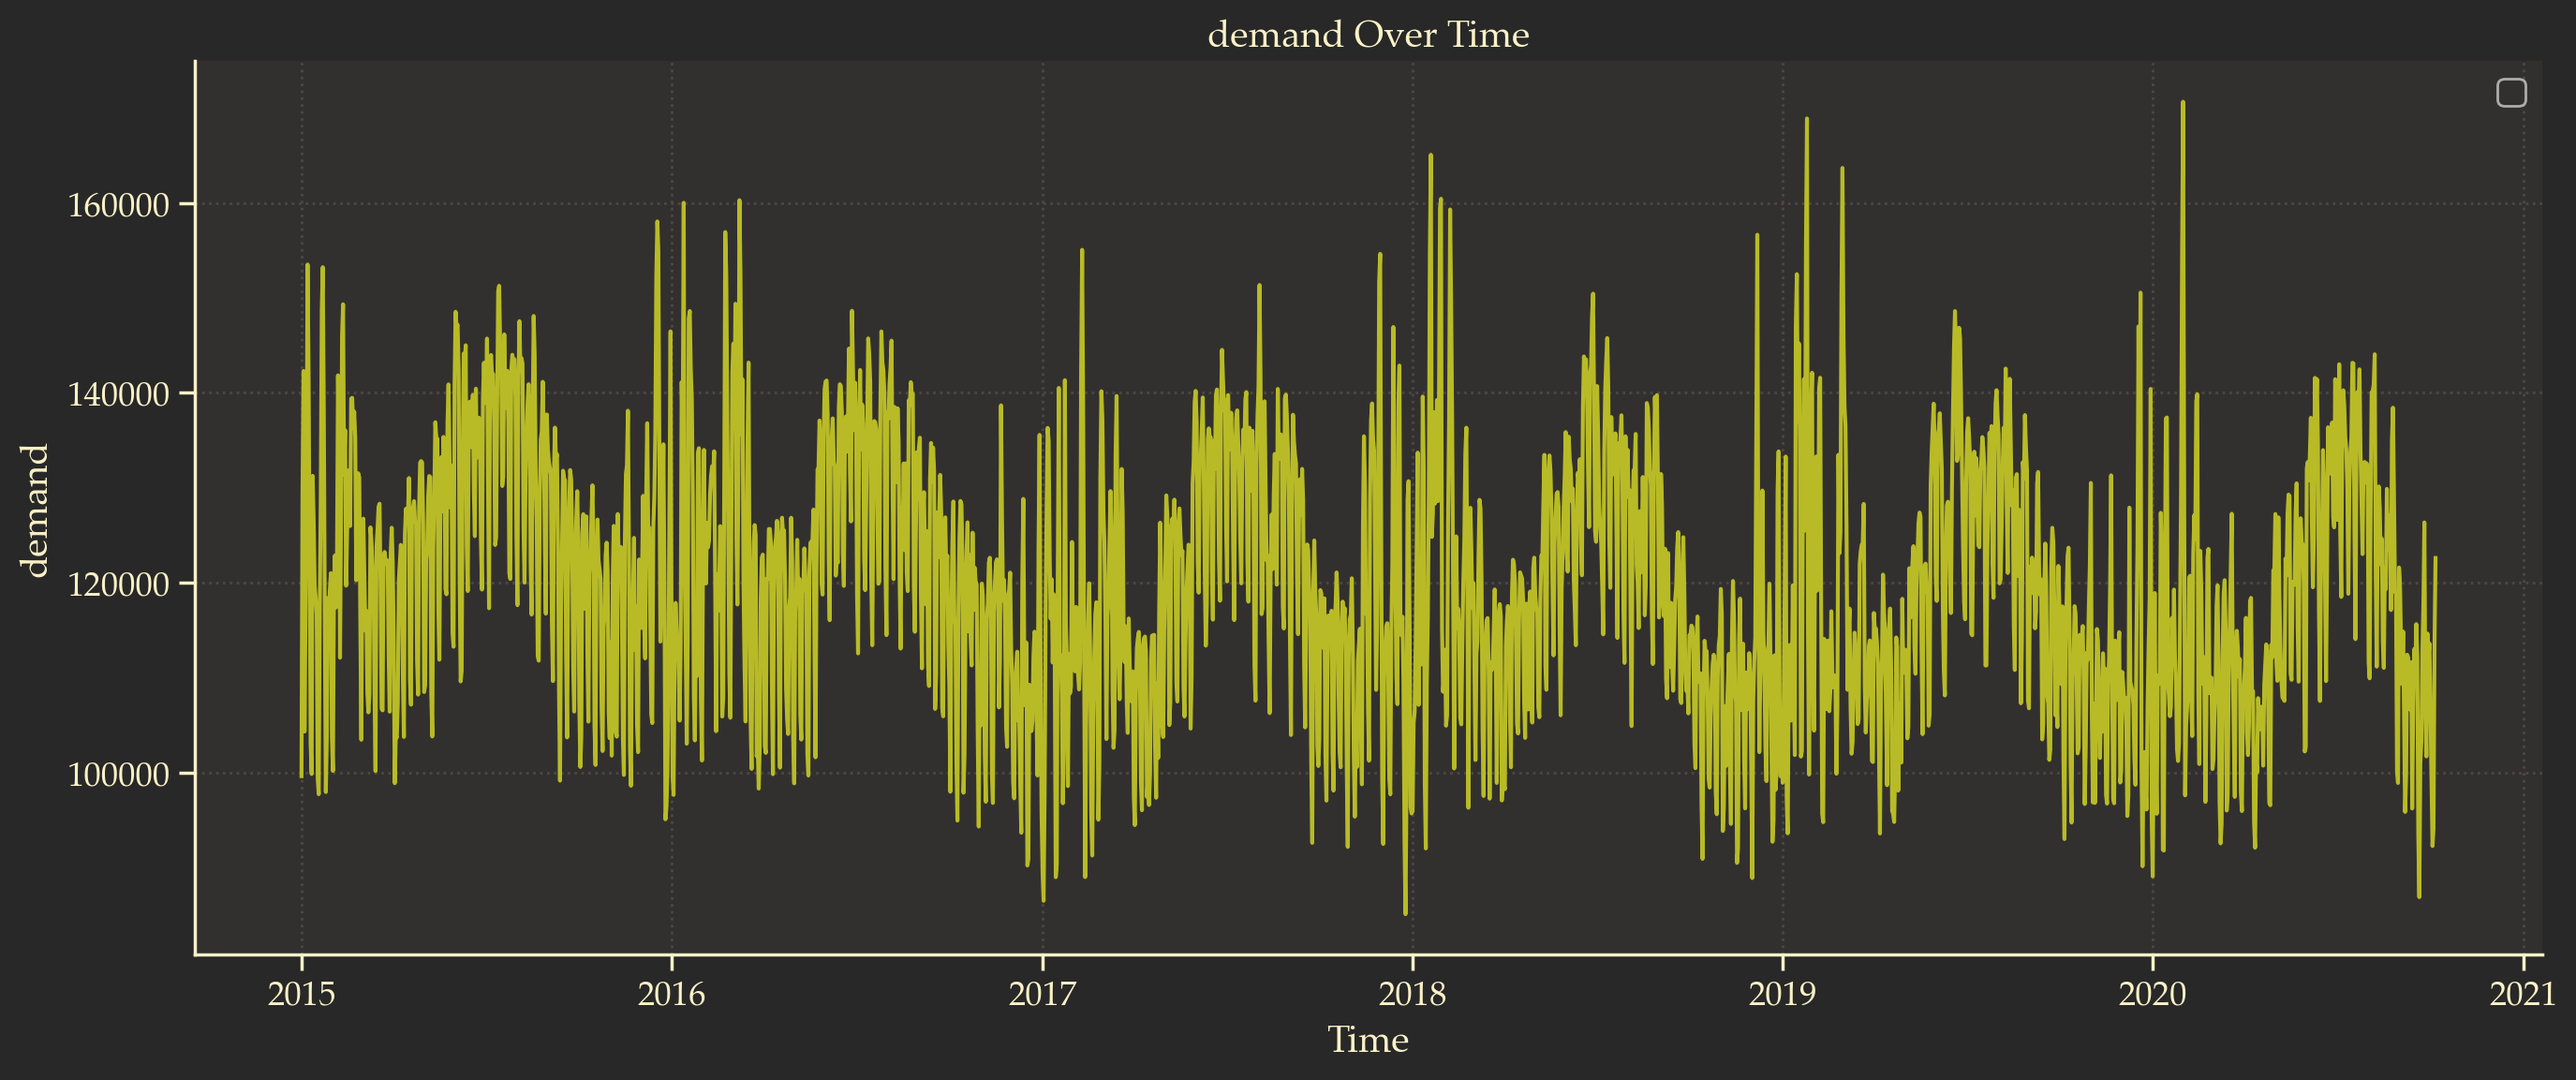

In [3]:
# Ensure timestamp column is in datetime format
timestamp_column = 'timestamp'  # Change this to match your actual column name

# Try to find a timestamp-like column if the specified one doesn't exist
if timestamp_column not in df.columns:
    possible_time_columns = [col for col in df.columns if any(x in col.lower() 
                                                             for x in ['time', 'date', 'hour', 'day'])]
    if possible_time_columns:
        timestamp_column = possible_time_columns[0]
        print(f"Using '{timestamp_column}' as the timestamp column")
    else:
        # If no obvious time column exists, create a dummy index
        print("No timestamp column found, creating a dummy time index")
        df['timestamp'] = pd.date_range(start='2022-01-01', periods=len(df), freq='H')
        timestamp_column = 'timestamp'

# Convert to datetime
if timestamp_column in df.columns:
    try:
        df[timestamp_column] = pd.to_datetime(df[timestamp_column])
        print(f"Converted '{timestamp_column}' to datetime")
    except:
        print(f"Error converting '{timestamp_column}' to datetime, creating a dummy time index")
        df['timestamp'] = pd.date_range(start='2022-01-01', periods=len(df), freq='H')
        timestamp_column = 'timestamp'

# Identify the demand column (assuming it contains 'demand', 'load', or 'consumption' in its name)
demand_columns = [col for col in df.columns if any(x in col.lower() 
                                                for x in ['demand', 'load', 'consumption', 'mw', 'kw'])]

if demand_columns:
    demand_column = demand_columns[0]
    print(f"Using '{demand_column}' as the demand column")
else:
    # If no obvious demand column exists, try to determine it from numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove any obvious non-demand columns
    exclude_words = ['price', 'cost', 'revenue', 'profit', 'temperature', 'humidity', 'wind', 'id']
    filtered_columns = [col for col in numeric_columns 
                        if not any(word in col.lower() for word in exclude_words)]
    
    if filtered_columns:
        demand_column = filtered_columns[0]
        print(f"No clear demand column found, using '{demand_column}' as the demand column")
    else:
        print("No suitable demand column found. Please verify your data and column names.")

# Set the timestamp as the index and sort data
if timestamp_column in df.columns:
    df = df.set_index(timestamp_column).sort_index()
    print("Set timestamp as index and sorted data")
    
# Check the time frequency
if len(df) > 1:
    time_diff = df.index.to_series().diff().value_counts().index[0]
    print(f"Data time frequency appears to be: {time_diff}")

# Plot demand
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[demand_column])
plt.title(f'{demand_column} Over Time')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




#### 4. Feature Engineering

Shape after adding features and dropping NaNs: (1935, 45)


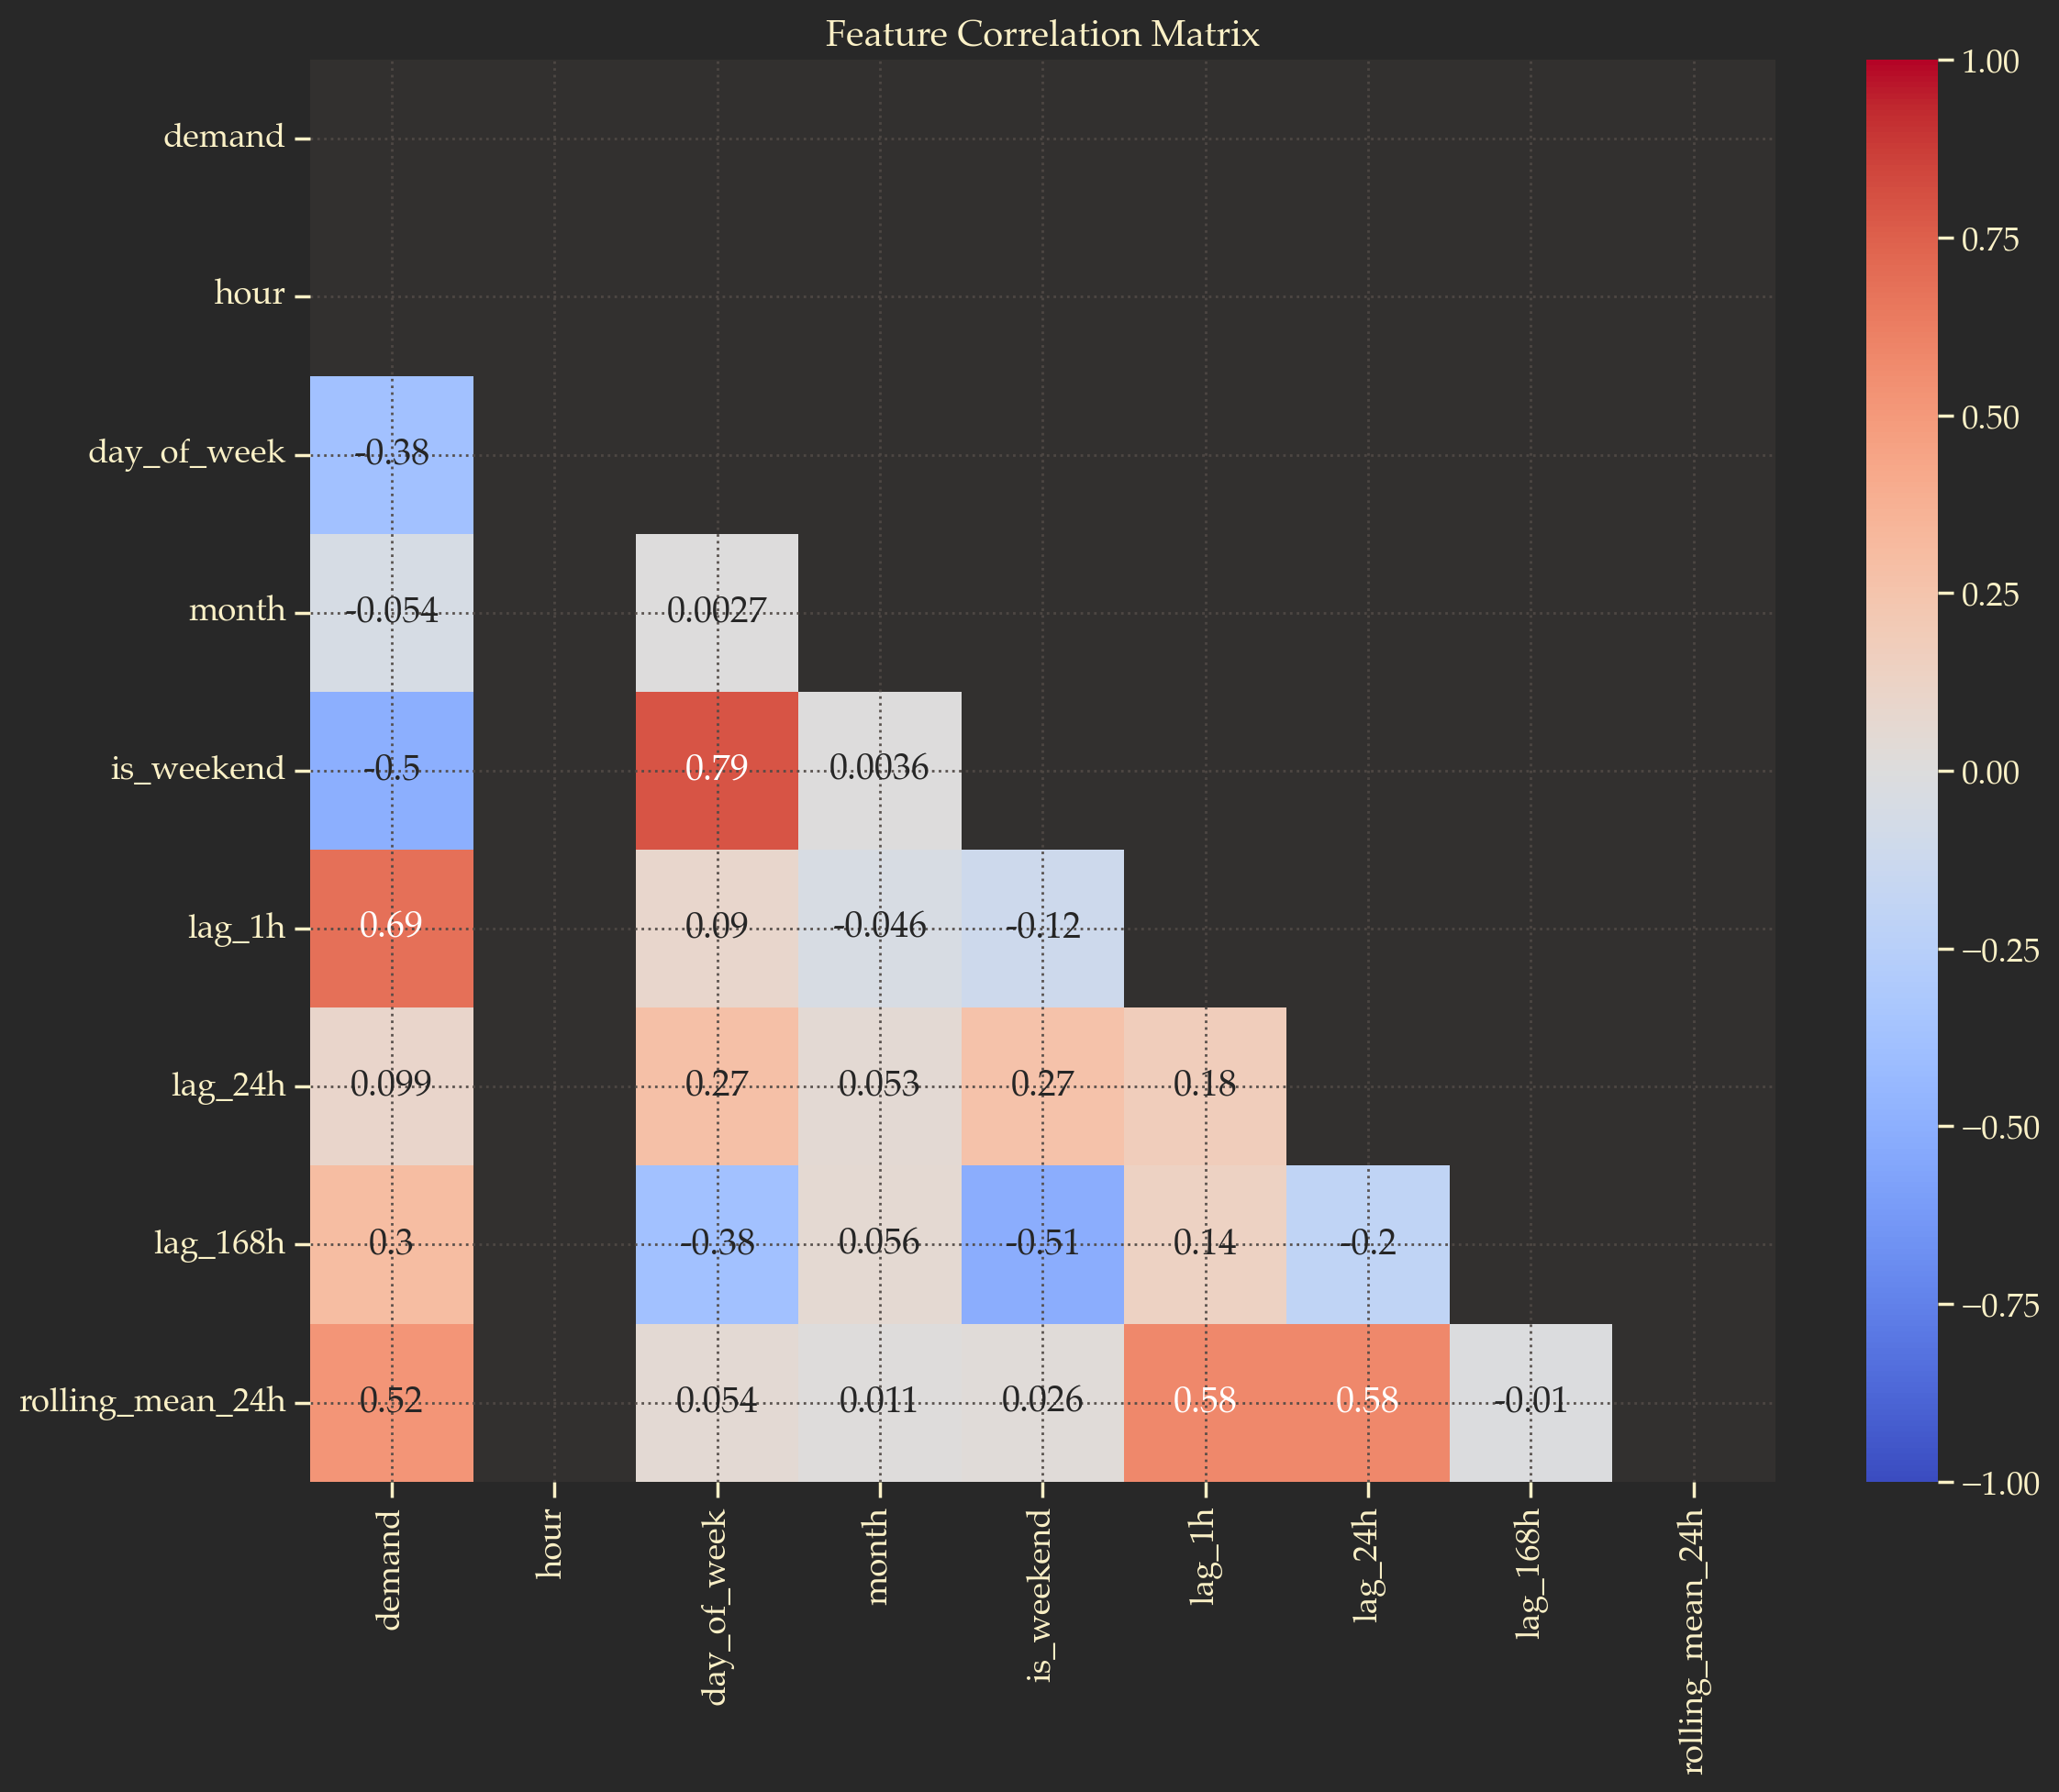

In [4]:
# Add time-based features
def add_time_features(df):
    """Add time-based features relevant for electricity demand"""
    # Make a copy to avoid modifying the original
    df_features = df.copy()
    
    # Basic time features
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['year'] = df_features.index.year
    df_features['day_of_year'] = df_features.index.dayofyear
    
    # Cyclical encoding of time features (to handle periodicity)
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['dow_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['dow_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # Is business day and is business hour
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_business_hour'] = ((df_features['hour'] >= 8) & 
                                       (df_features['hour'] <= 18) & 
                                       ~df_features['is_weekend']).astype(int)
    
    return df_features

# Add lag features and rolling statistics
def add_lag_features(df, target_col, lag_hours=[1, 24, 48, 168], 
                     rolling_windows=[3, 6, 12, 24, 168]):
    """
    Add lag features and rolling statistics for the target column
    lag_hours: List of hours to lag
    rolling_windows: List of window sizes for rolling statistics
    """
    df_features = df.copy()
    
    # Add lag features
    for lag in lag_hours:
        df_features[f'lag_{lag}h'] = df_features[target_col].shift(lag)
    
    # Add rolling statistics
    for window in rolling_windows:
        df_features[f'rolling_mean_{window}h'] = df_features[target_col].rolling(window=window).mean().shift(1)
        df_features[f'rolling_std_{window}h'] = df_features[target_col].rolling(window=window).std().shift(1)
        df_features[f'rolling_max_{window}h'] = df_features[target_col].rolling(window=window).max().shift(1)
    
    return df_features

# Apply feature engineering functions
df_with_features = add_time_features(df)
df_with_features = add_lag_features(df_with_features, demand_column)

# Drop rows with NaN values (resulting from lag features)
df_with_features = df_with_features.dropna()
print(f"Shape after adding features and dropping NaNs: {df_with_features.shape}")

# Plot correlation matrix for the most relevant features
# Select a subset of features to keep the plot readable
feature_subset = [demand_column, 'hour', 'day_of_week', 'month', 'is_weekend', 
                 'lag_1h', 'lag_24h', 'lag_168h', 'rolling_mean_24h']

plt.figure(figsize=(12, 10))
correlation_matrix = df_with_features[feature_subset].corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()



#### 5. Data Splitting and Preprocessing

In [5]:
# Define features and target variable
# Exclude any non-feature columns (like IDs or text descriptions) or non-numeric columns
exclude_cols = ['event_group'] if 'event_group' in df_with_features.columns else []

# Check data types and handle non-numeric columns
for col in df_with_features.columns:
    if col != demand_column and col not in exclude_cols:
        if df_with_features[col].dtype == 'object':
            print(f"Converting non-numeric column '{col}' to categorical")
            # Use pandas get_dummies for categorical columns
            dummies = pd.get_dummies(df_with_features[col], prefix=col, drop_first=True)
            df_with_features = pd.concat([df_with_features, dummies], axis=1)
            exclude_cols.append(col)  # Add to exclude list since we've created dummy variables

# Now select only numeric columns for features
feature_cols = [col for col in df_with_features.columns 
                if col != demand_column and col not in exclude_cols and 
                pd.api.types.is_numeric_dtype(df_with_features[col])]
               
X = df_with_features[feature_cols]
y = df_with_features[demand_column]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Verify no non-numeric data remains
print("Data types in feature set:")
print(X.dtypes.value_counts())


# Split the data - using time series split to respect temporal ordering
# Use the last 20% of data for testing
split_idx = int(len(df_with_features) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Testing period: {X_test.index[0]} to {X_test.index[-1]}")


# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable for neural network training
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

print("Data scaling complete!")

Converting non-numeric column 'school_day' to categorical
Converting non-numeric column 'holiday' to categorical
Number of features: 44
Features: ['RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'hour', 'day_of_week', 'month', 'year', 'day_of_year', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_business_hour', 'lag_1h', 'lag_24h', 'lag_48h', 'lag_168h', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_max_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_max_6h', 'rolling_mean_12h', 'rolling_std_12h', 'rolling_max_12h', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_max_24h', 'rolling_mean_168h', 'rolling_std_168h', 'rolling_max_168h', 'school_day_Y', 'holiday_Y']
Data types in feature set:
float64    35
int32       5
int64       2
bool        2
Name: count, dtype: int64
Training set size: 1548
Testing set size: 387
Training period

#### 6. Model 1: Gradient Boosting

Training XGBoost model...
XGBoost model training complete!
XGBoost Model Results:
MAE: 757.14
RMSE: 1999.63
R²: 0.9770


<Figure size 2400x1600 with 0 Axes>

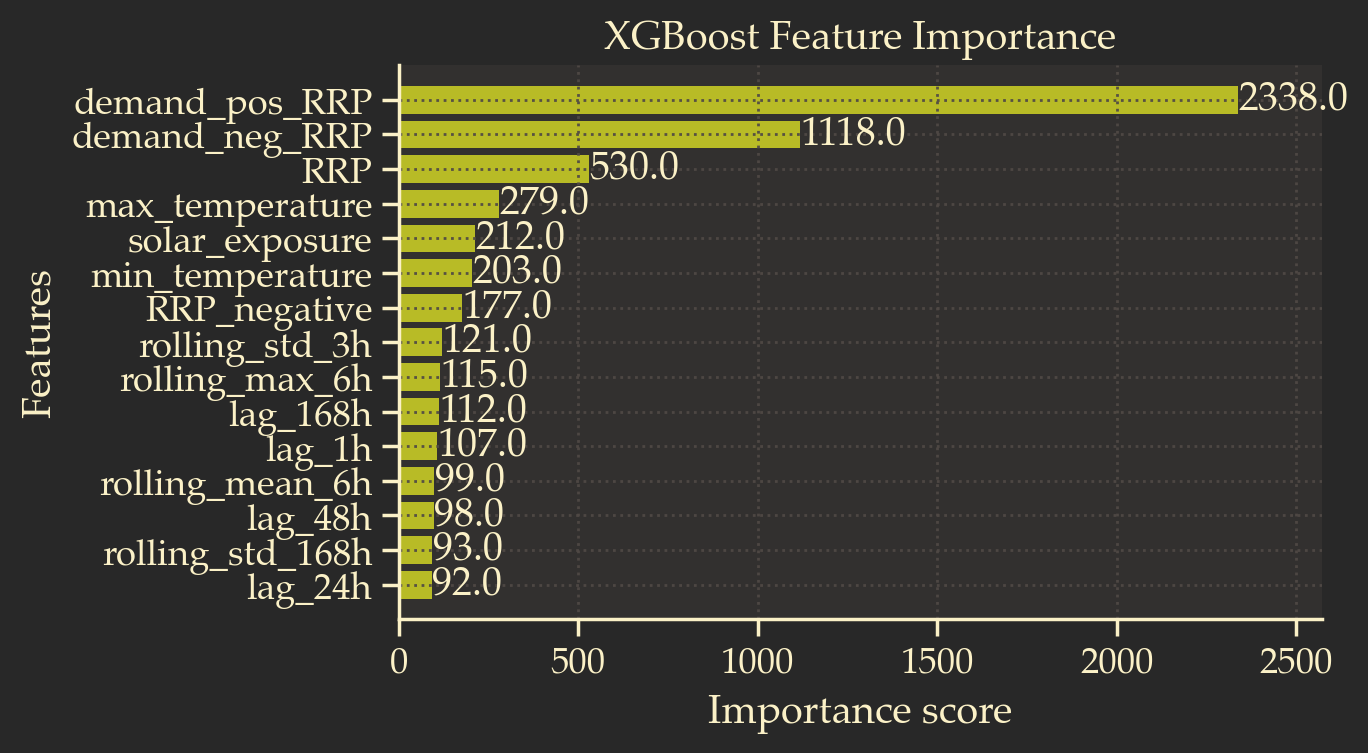

In [6]:
# Train XGBoost model with simplified parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
print("Training XGBoost model...")
# Simplest form of fit without any extra parameters
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete!")

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
# Calculate metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Model Results:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

#### 7. Model 2: LightGBM

In [7]:
# Train LightGBM model with simplified parameters
lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

print("Training LightGBM model...")
# Simplest form of fit with no extra parameters
lgbm_model.fit(X_train, y_train)
print("LightGBM model training complete!")


# Make predictions and evaluate
y_pred_lgbm = lgbm_model.predict(X_test)

# Calculate metrics
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Model Results:")
print(f"MAE: {mae_lgbm:.2f}")
print(f"RMSE: {rmse_lgbm:.2f}")
print(f"R²: {r2_lgbm:.4f}")

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6328
[LightGBM] [Info] Number of data points in the train set: 1548, number of used features: 40
[LightGBM] [Info] Start training from score 120852.611747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

#### 8. Model 3: LTSM Neural Network

LSTM training sequences shape: (1524, 24, 44)
LSTM testing sequences shape: (363, 24, 44)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        19,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,751 (112.31 KB)

 Trainable params: 28,751 (112.31 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1931 - val_loss: 0.0257
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.0266
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - val_loss: 0.0211
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212 - val_loss: 0.0190
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - val_loss: 0.0186
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0193
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0206
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - val_loss: 0.0175
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0161
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 

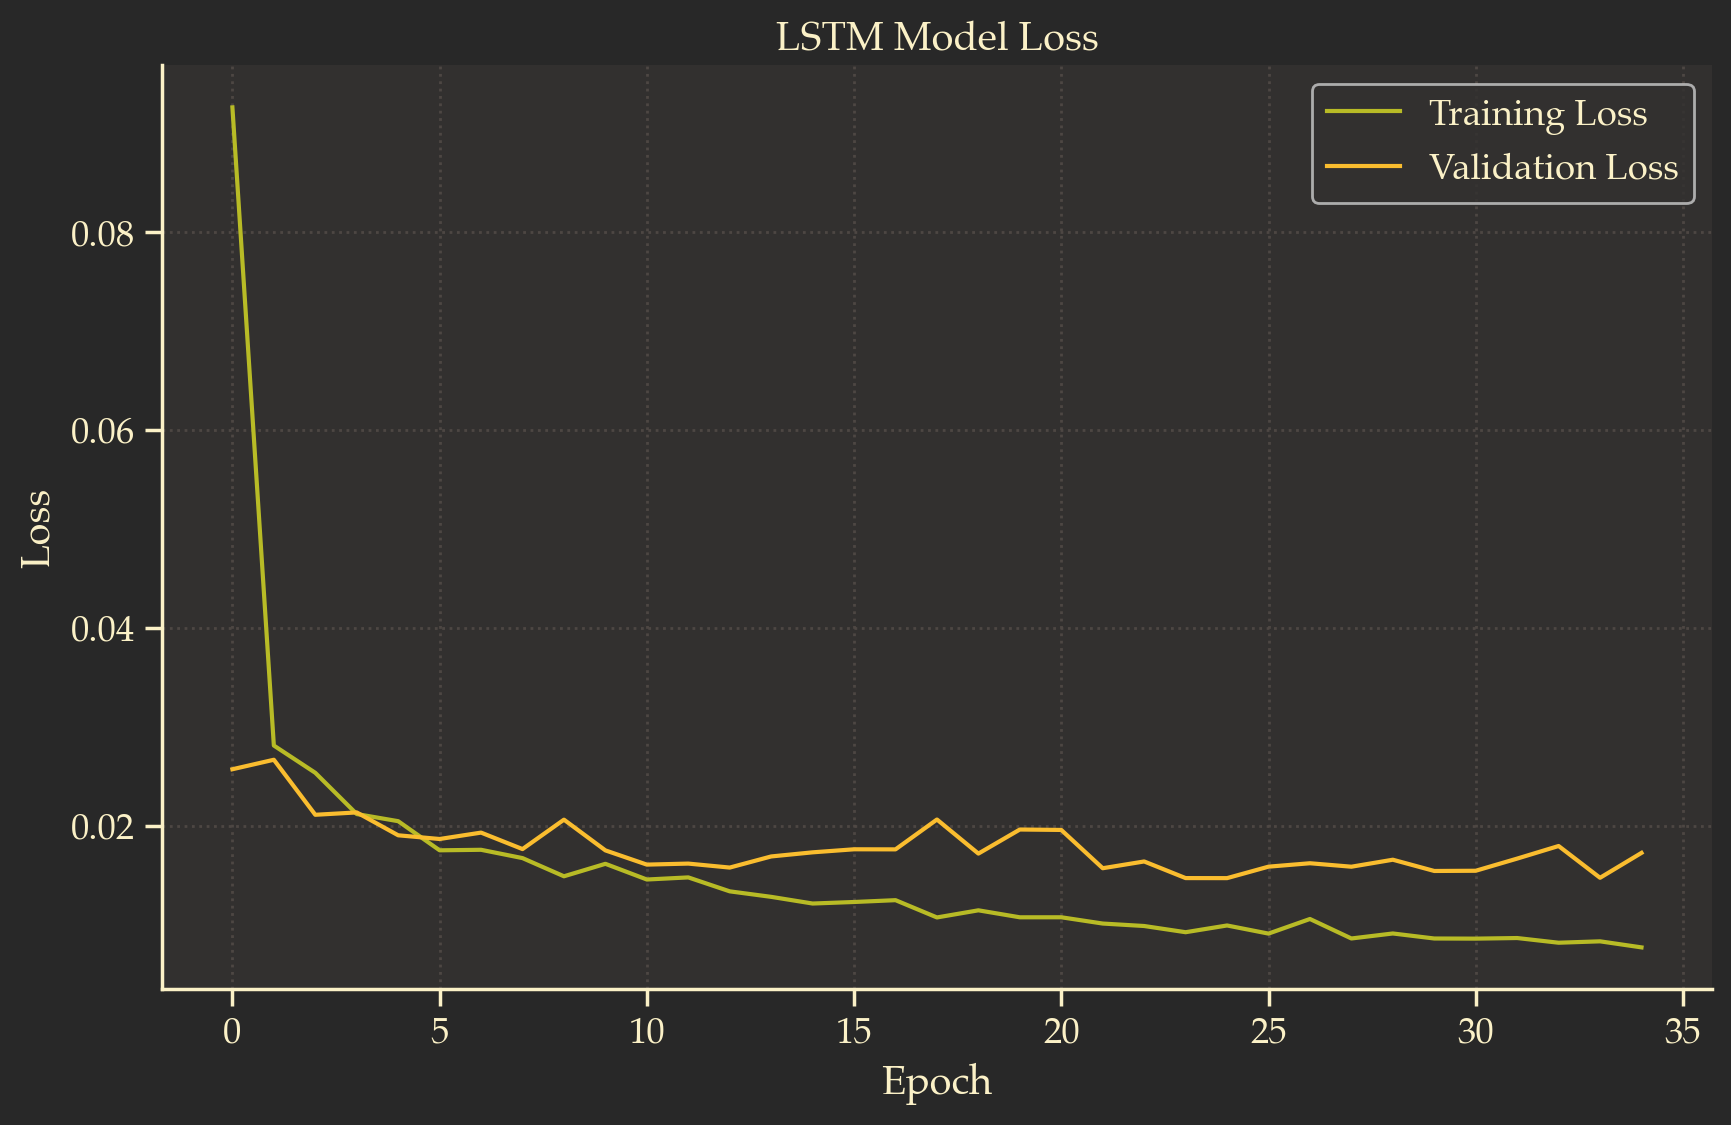

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM Model Results:
MAE: 7652.99
RMSE: 10048.89
R²: 0.4387


In [8]:
# Prepare data for LSTM (need to reshape)
# We'll use a sequence length of 24 hours to predict the next hour
def create_sequences(X, y, seq_length=24):
    """Create sequences for LSTM model"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


# Create sequences for LSTM
seq_length = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f"LSTM training sequences shape: {X_train_seq.shape}")
print(f"LSTM testing sequences shape: {X_test_seq.shape}")


# Build and train LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X_train.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(30, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model
lstm_model.compile(optimizer='adam', loss='mse')

# Setup early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Display model summary
lstm_model.summary()


# Train LSTM model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("LSTM model training complete!")


# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Make predictions and evaluate LSTM
y_pred_lstm_scaled = lstm_model.predict(X_test_seq)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)

# We need to adjust the test set to match the sequence data size
y_test_lstm = y_test[seq_length:].values.reshape(-1, 1)

# Calculate metrics
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"LSTM Model Results:")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.4f}")



#### 9. Ensemble Model

Test set size for ensemble: 363
XGBoost predictions size: 363
LightGBM predictions size: 363
LSTM predictions size: 363
Ensemble weights:
XGBoost: 0.4083
LightGBM: 0.4084
LSTM: 0.1833
Ensemble Model Results:
MAE: 1669.25
RMSE: 2434.79
R²: 0.9670


Model          MAE          RMSE        R²
0   XGBoost   757.136996   1999.626805  0.976990
1  LightGBM   834.972730   1985.714278  0.977309
2      LSTM  7652.990459  10048.892624  0.438720
3  Ensemble  1669.245438   2434.787689  0.967049

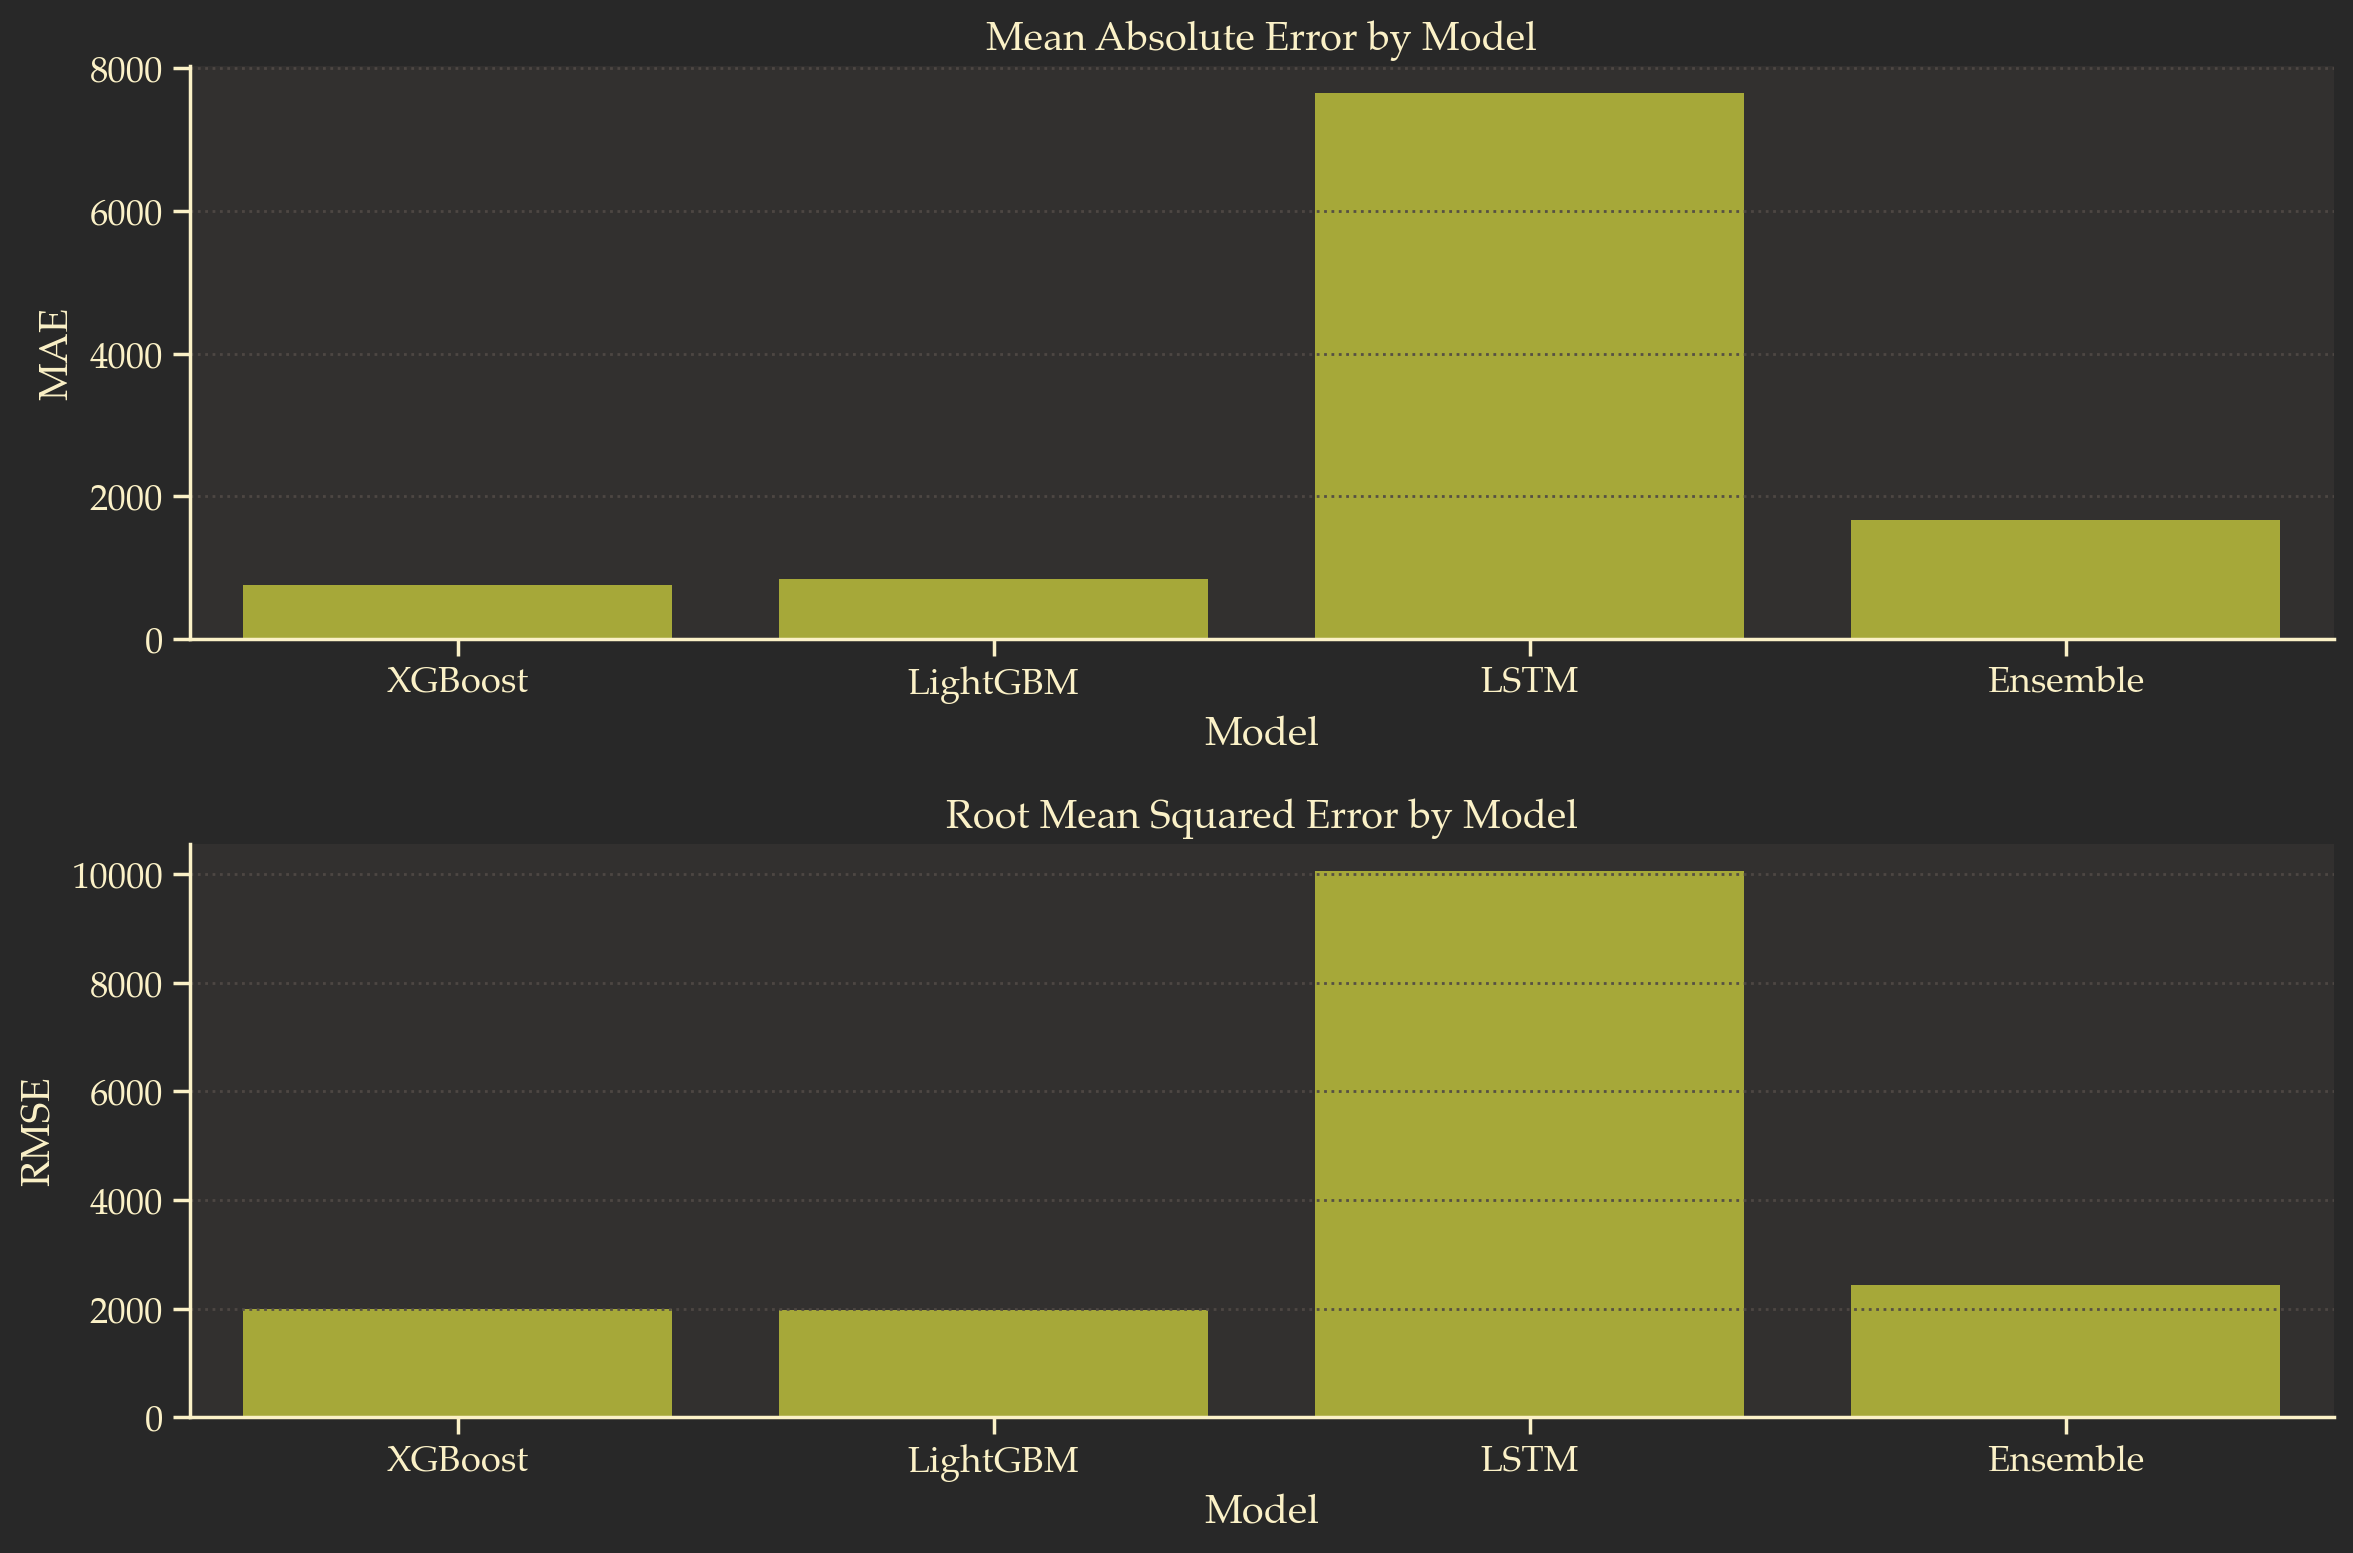

In [9]:
# Create an ensemble by averaging predictions
# First, ensure all predictions are for the same time periods
# (LSTM predictions start seq_length steps later)
y_test_ensemble = y_test[seq_length:].values
y_pred_xgb_ensemble = y_pred_xgb[seq_length:]
y_pred_lgbm_ensemble = y_pred_lgbm[seq_length:]
y_pred_lstm_ensemble = y_pred_lstm.flatten()

# Check that all arrays have the same length
print(f"Test set size for ensemble: {len(y_test_ensemble)}")
print(f"XGBoost predictions size: {len(y_pred_xgb_ensemble)}")
print(f"LightGBM predictions size: {len(y_pred_lgbm_ensemble)}")
print(f"LSTM predictions size: {len(y_pred_lstm_ensemble)}")


# Create ensemble prediction (weighted average)
# Optimize weights based on individual model performance
total_r2 = r2_xgb + r2_lgbm + r2_lstm
weight_xgb = r2_xgb / total_r2
weight_lgbm = r2_lgbm / total_r2
weight_lstm = r2_lstm / total_r2

y_pred_ensemble = (
    weight_xgb * y_pred_xgb_ensemble + 
    weight_lgbm * y_pred_lgbm_ensemble + 
    weight_lstm * y_pred_lstm_ensemble
)

print(f"Ensemble weights:")
print(f"XGBoost: {weight_xgb:.4f}")
print(f"LightGBM: {weight_lgbm:.4f}")
print(f"LSTM: {weight_lstm:.4f}")


# Evaluate ensemble model
mae_ensemble = mean_absolute_error(y_test_ensemble, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_ensemble, y_pred_ensemble))
r2_ensemble = r2_score(y_test_ensemble, y_pred_ensemble)

print(f"Ensemble Model Results:")
print(f"MAE: {mae_ensemble:.2f}")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"R²: {r2_ensemble:.4f}")


# Compare all models
results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'LSTM', 'Ensemble'],
    'MAE': [mae_xgb, mae_lgbm, mae_lstm, mae_ensemble],
    'RMSE': [rmse_xgb, rmse_lgbm, rmse_lstm, rmse_ensemble],
    'R²': [r2_xgb, r2_lgbm, r2_lstm, r2_ensemble]
})

display(results_df)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(data=results_df, x='Model', y='MAE')
plt.title('Mean Absolute Error by Model')
plt.subplot(2, 1, 2)
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title('Root Mean Squared Error by Model')
plt.tight_layout()
plt.show()



#### 10. Visualizing Predictions and Peak Events

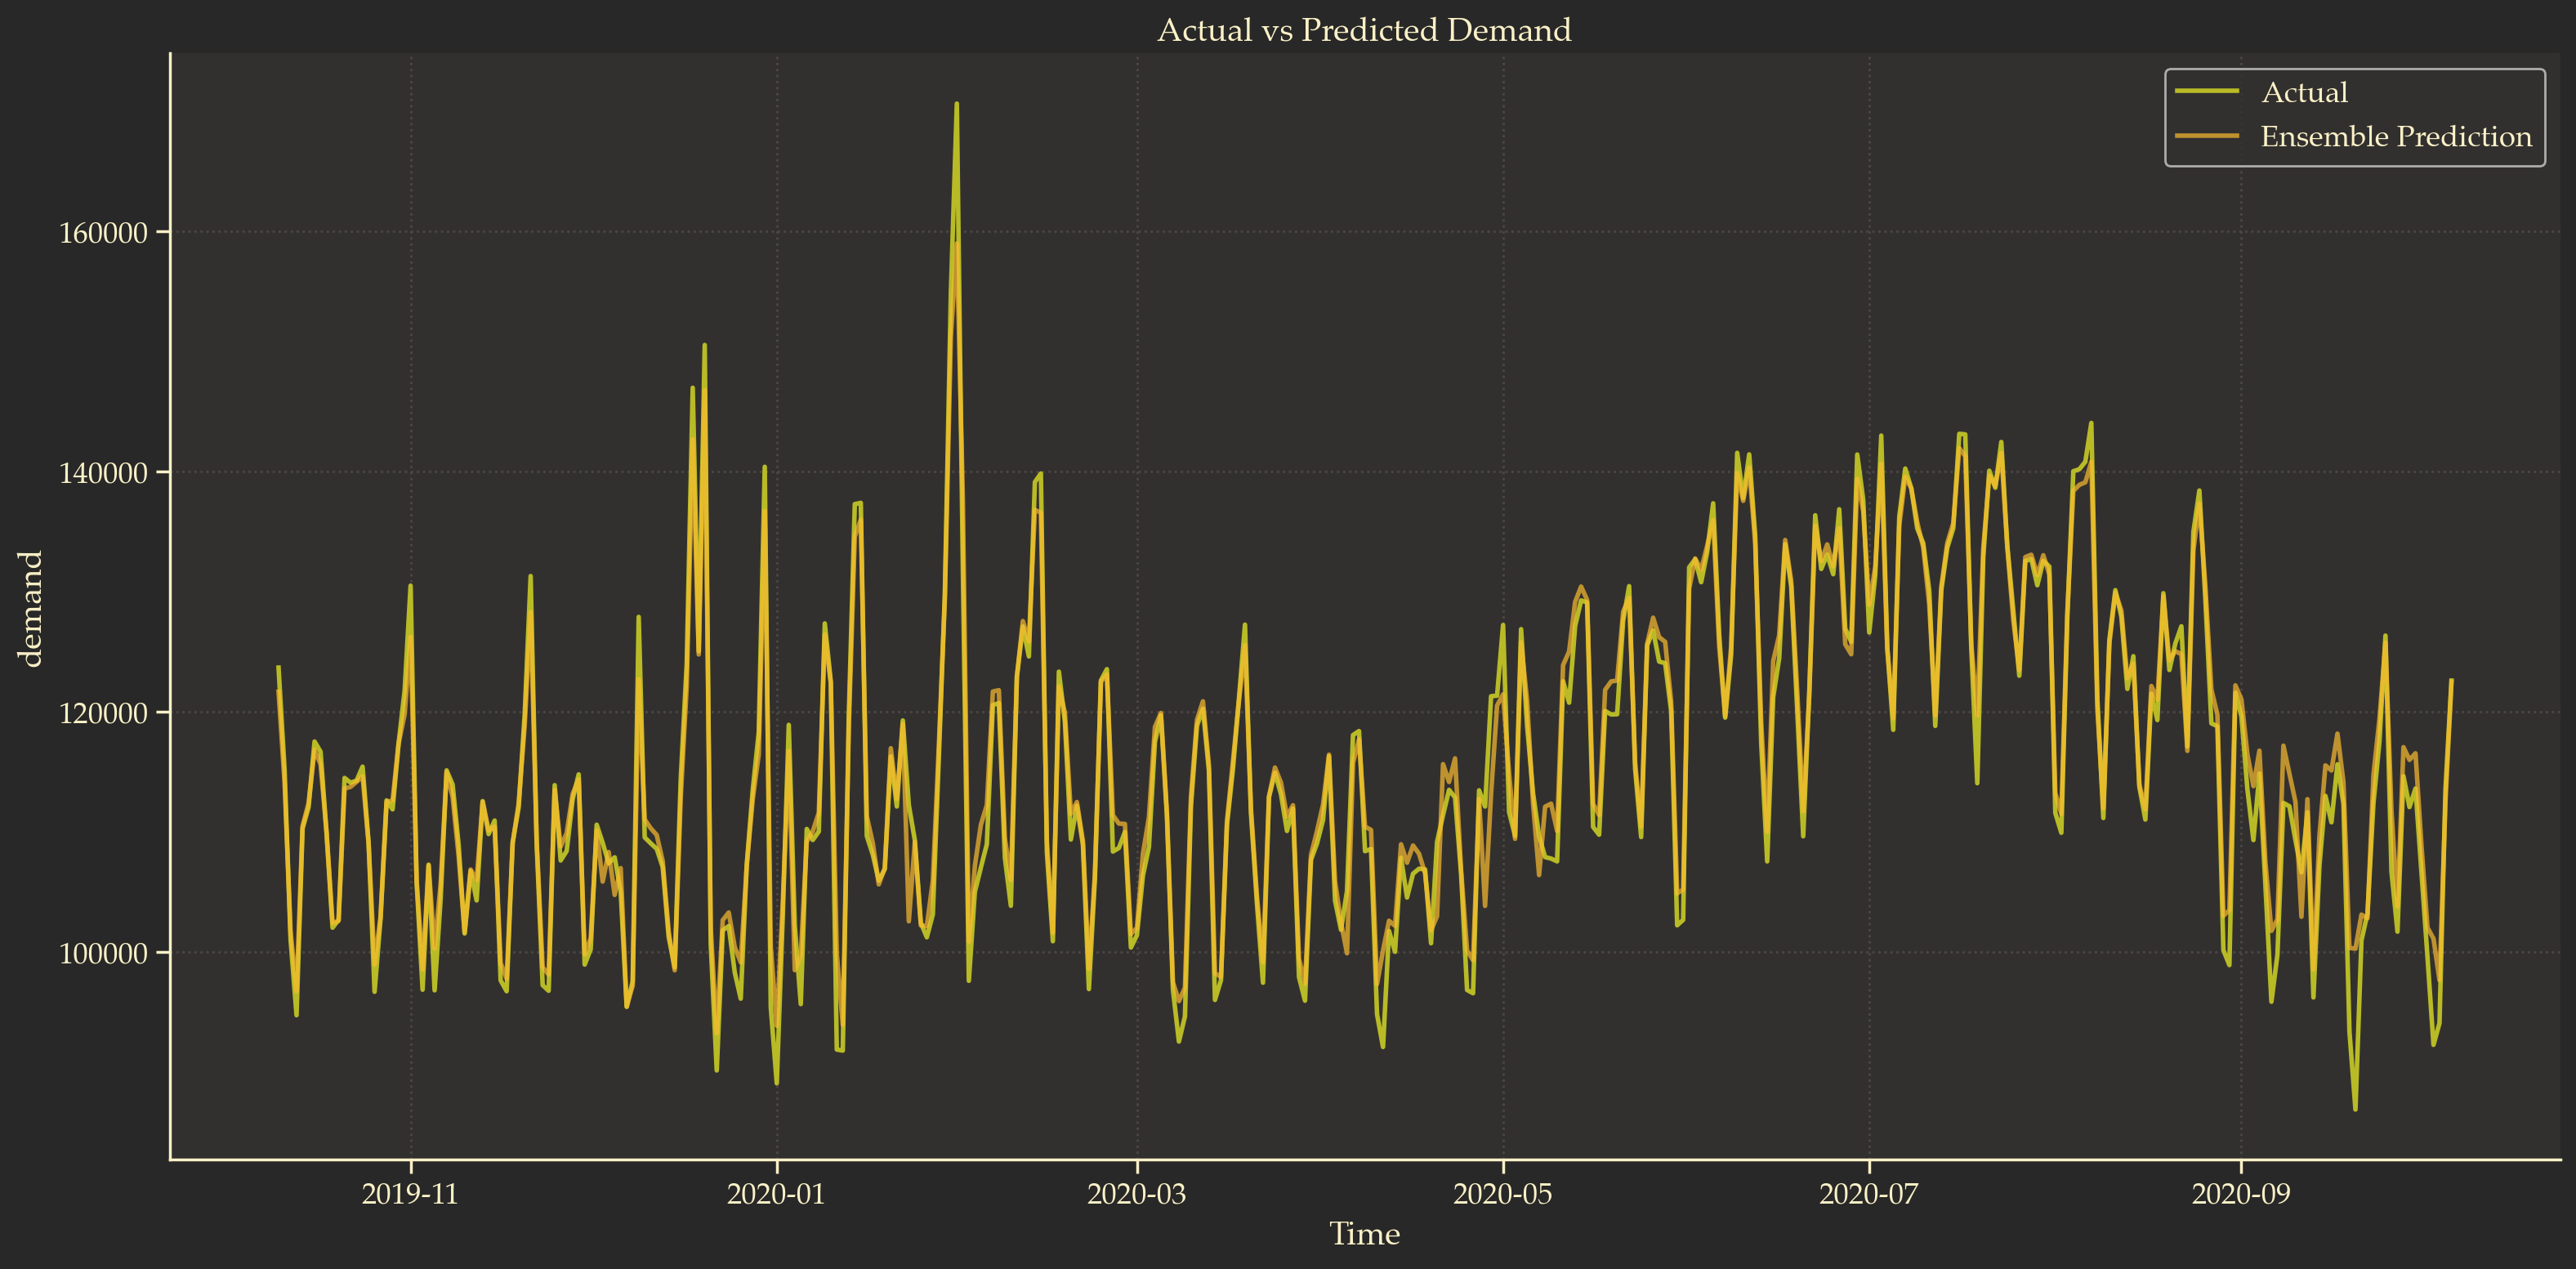

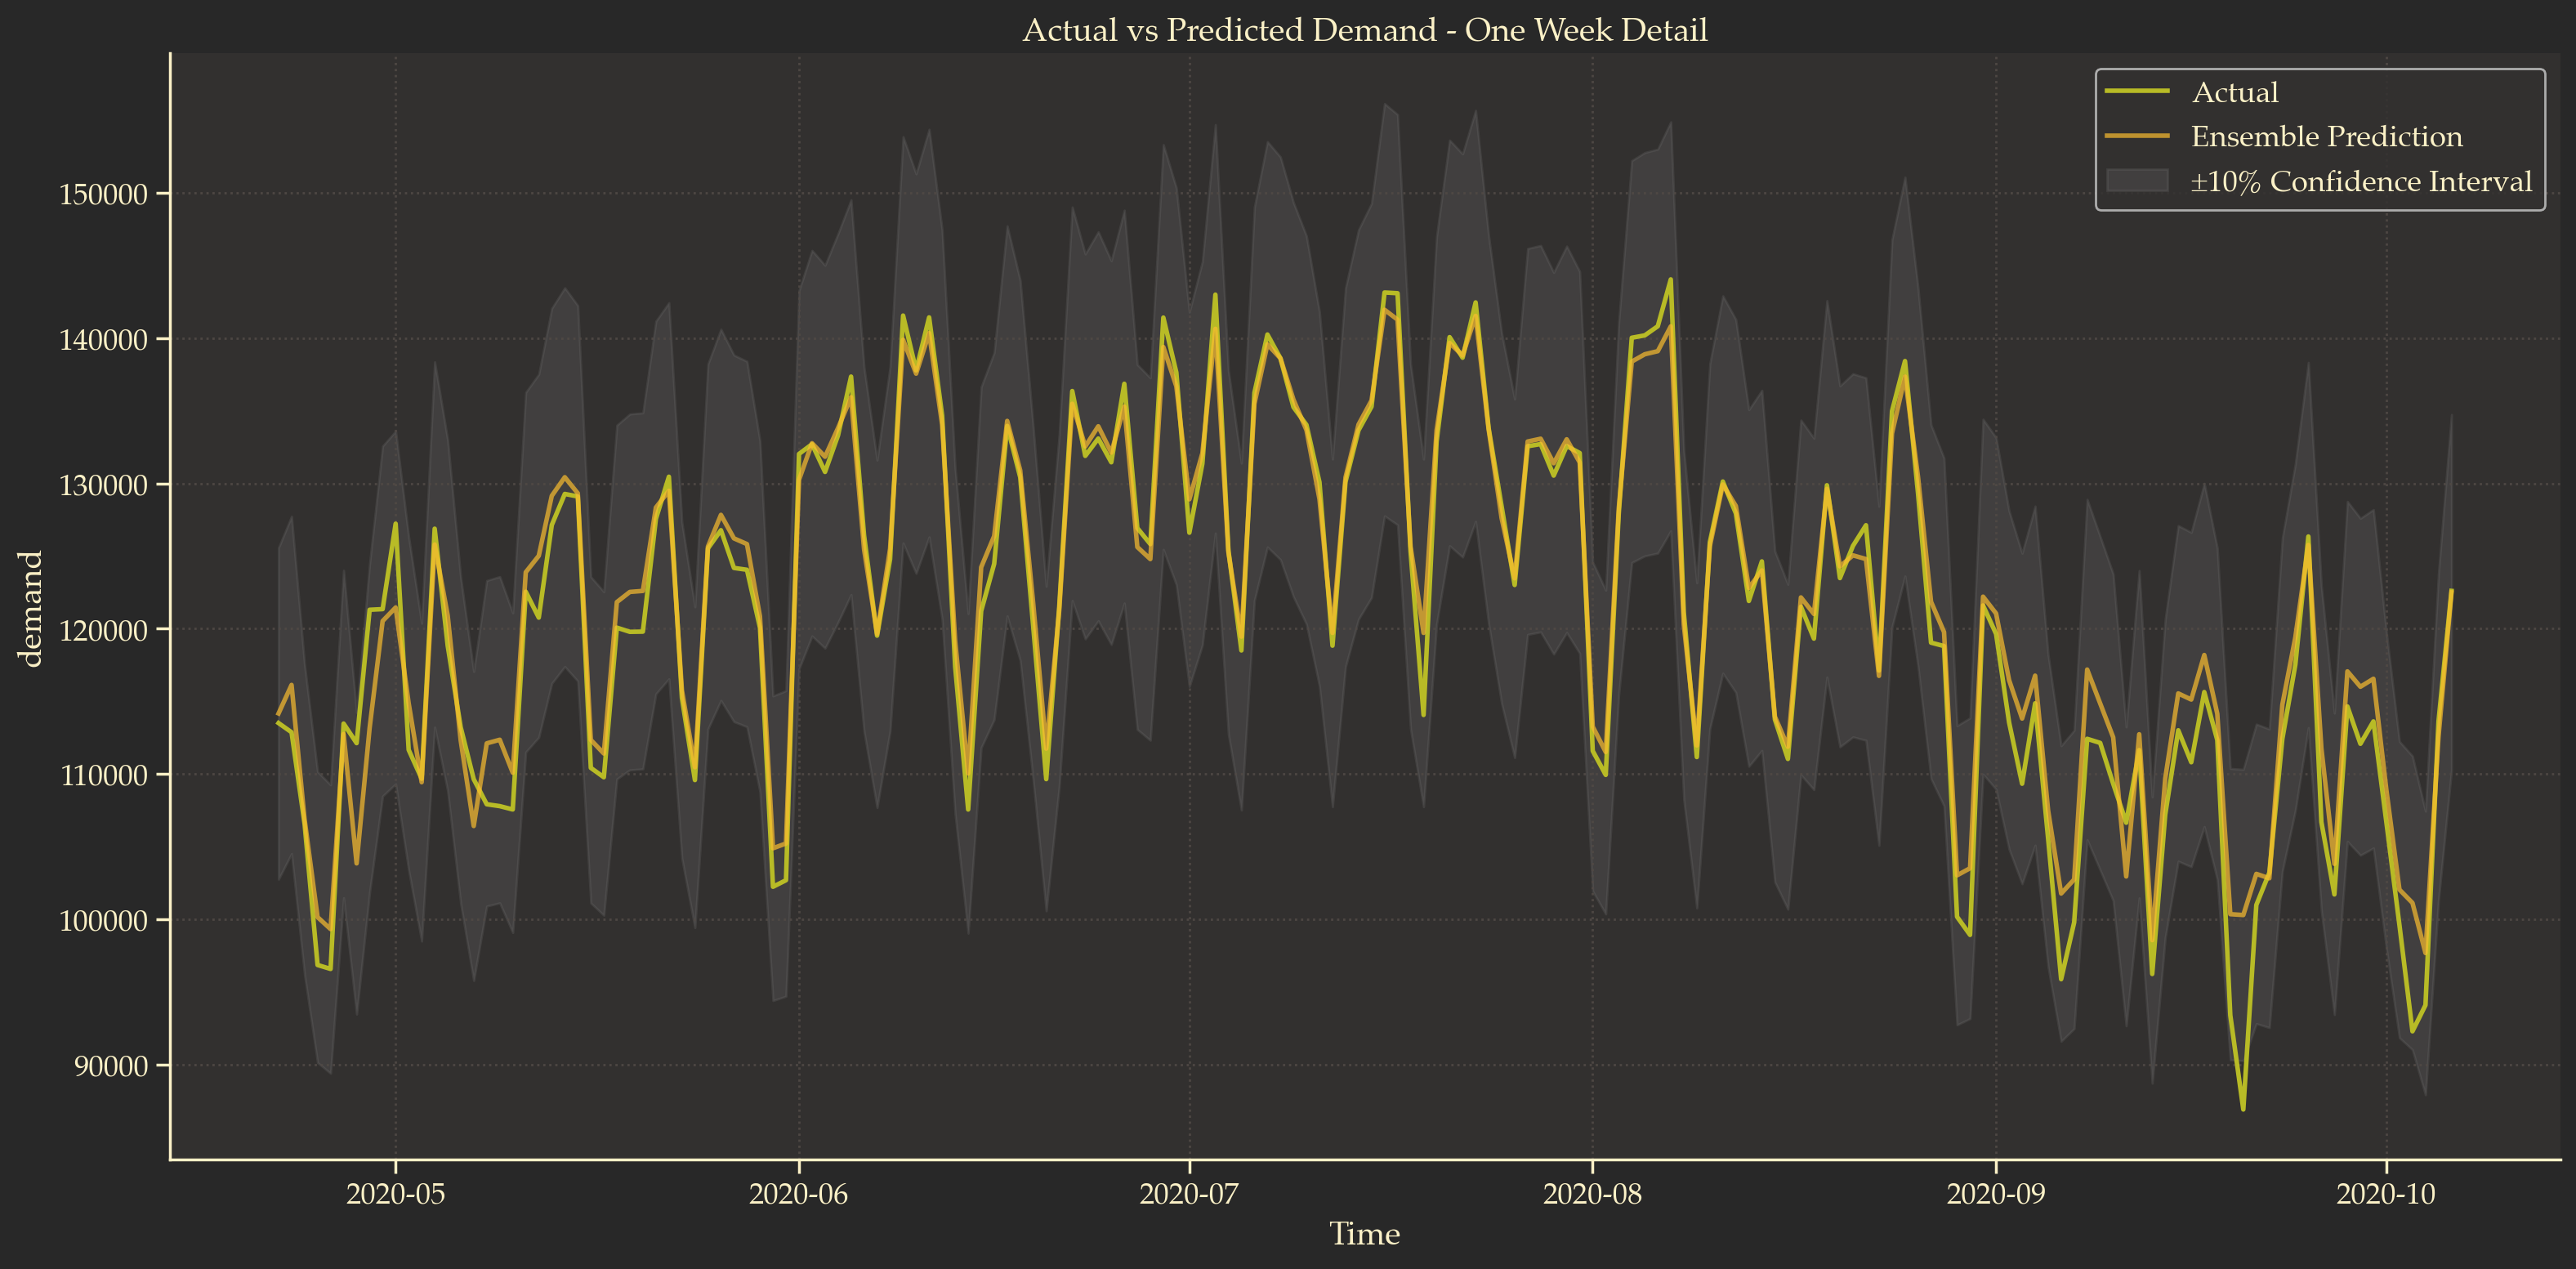

Peak Event Prediction Results:
Overall Accuracy: 0.9780
Peak Precision: 1.0000
Peak Recall: 0.5789
True Positives: 11
False Positives: 0
False Negatives: 8


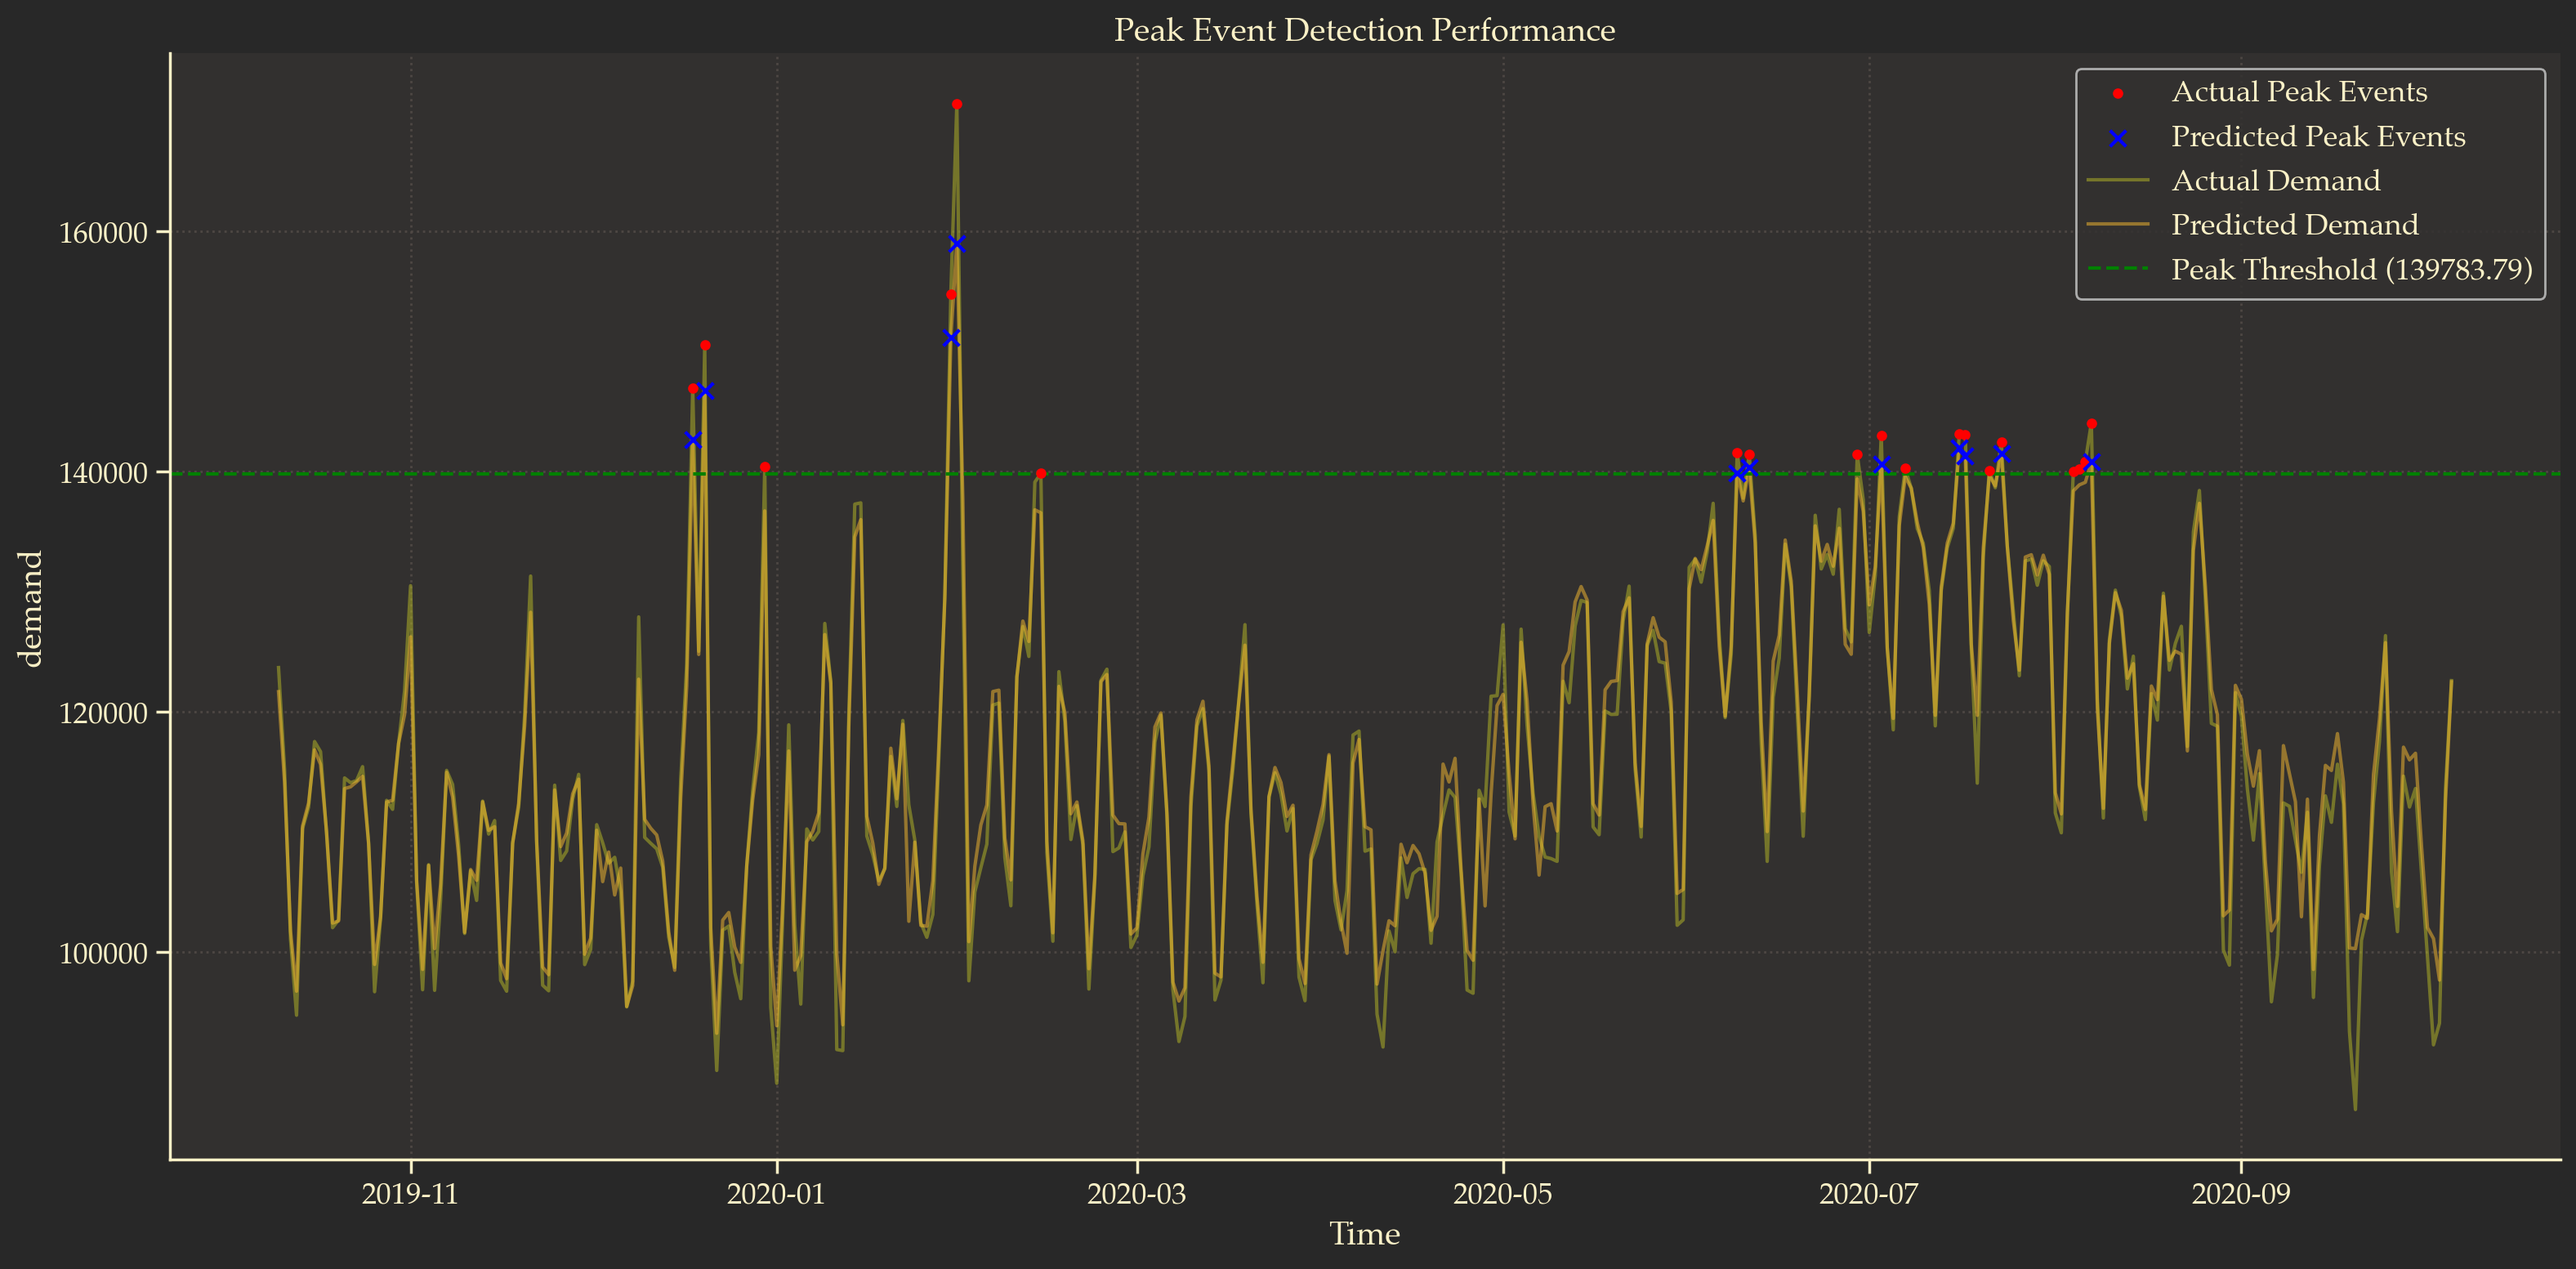

In [10]:
# Create a DataFrame with all test results for visualization
results = pd.DataFrame({
    'timestamp': y_test[seq_length:].index,
    'actual': y_test_ensemble,
    'xgboost': y_pred_xgb_ensemble,
    'lightgbm': y_pred_lgbm_ensemble,
    'lstm': y_pred_lstm_ensemble,
    'ensemble': y_pred_ensemble
})


# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(results['timestamp'], results['actual'], label='Actual', linewidth=2)
plt.plot(results['timestamp'], results['ensemble'], label='Ensemble Prediction', linewidth=2, alpha=0.7)
plt.title('Actual vs Predicted Demand')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Zoom in on a specific time period (e.g., one week)
# Choose a week with interesting patterns
results_subset = results.set_index('timestamp').iloc[-24*7:].copy()  # Last week

plt.figure(figsize=(16, 8))
plt.plot(results_subset.index, results_subset['actual'], label='Actual', linewidth=2)
plt.plot(results_subset.index, results_subset['ensemble'], label='Ensemble Prediction', linewidth=2, alpha=0.7)
plt.fill_between(
    results_subset.index,
    results_subset['ensemble'] * 0.9,
    results_subset['ensemble'] * 1.1,
    color='gray', alpha=0.2, label='±10% Confidence Interval'
)
plt.title('Actual vs Predicted Demand - One Week Detail')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Identify peak events in the test period
peak_threshold = results['actual'].quantile(0.95)
results['is_peak'] = results['actual'] > peak_threshold
results['peak_predicted'] = results['ensemble'] > peak_threshold

# Calculate peak prediction metrics
peak_accuracy = (results['is_peak'] == results['peak_predicted']).mean()
true_positives = ((results['is_peak']) & (results['peak_predicted'])).sum()
false_positives = ((~results['is_peak']) & (results['peak_predicted'])).sum()
false_negatives = ((results['is_peak']) & (~results['peak_predicted'])).sum()

# Calculate precision and recall for peak events
if true_positives + false_positives > 0:
    peak_precision = true_positives / (true_positives + false_positives)
else:
    peak_precision = 0
    
if true_positives + false_negatives > 0:
    peak_recall = true_positives / (true_positives + false_negatives)
else:
    peak_recall = 0

print(f"Peak Event Prediction Results:")
print(f"Overall Accuracy: {peak_accuracy:.4f}")
print(f"Peak Precision: {peak_precision:.4f}")
print(f"Peak Recall: {peak_recall:.4f}")
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")


# Visualize peak events
plt.figure(figsize=(16, 8))
plt.scatter(results[results['is_peak']]['timestamp'], 
           results[results['is_peak']]['actual'],
           color='red', label='Actual Peak Events', s=50, zorder=5)
plt.scatter(results[results['peak_predicted']]['timestamp'], 
           results[results['peak_predicted']]['ensemble'],
           color='blue', marker='x', label='Predicted Peak Events', s=50, zorder=5)
plt.plot(results['timestamp'], results['actual'], label='Actual Demand', alpha=0.5)
plt.plot(results['timestamp'], results['ensemble'], label='Predicted Demand', alpha=0.5)
plt.axhline(y=peak_threshold, color='green', linestyle='--', label=f'Peak Threshold ({peak_threshold:.2f})')
plt.title('Peak Event Detection Performance')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Creating a ' What-If ' Analysis Dashboard

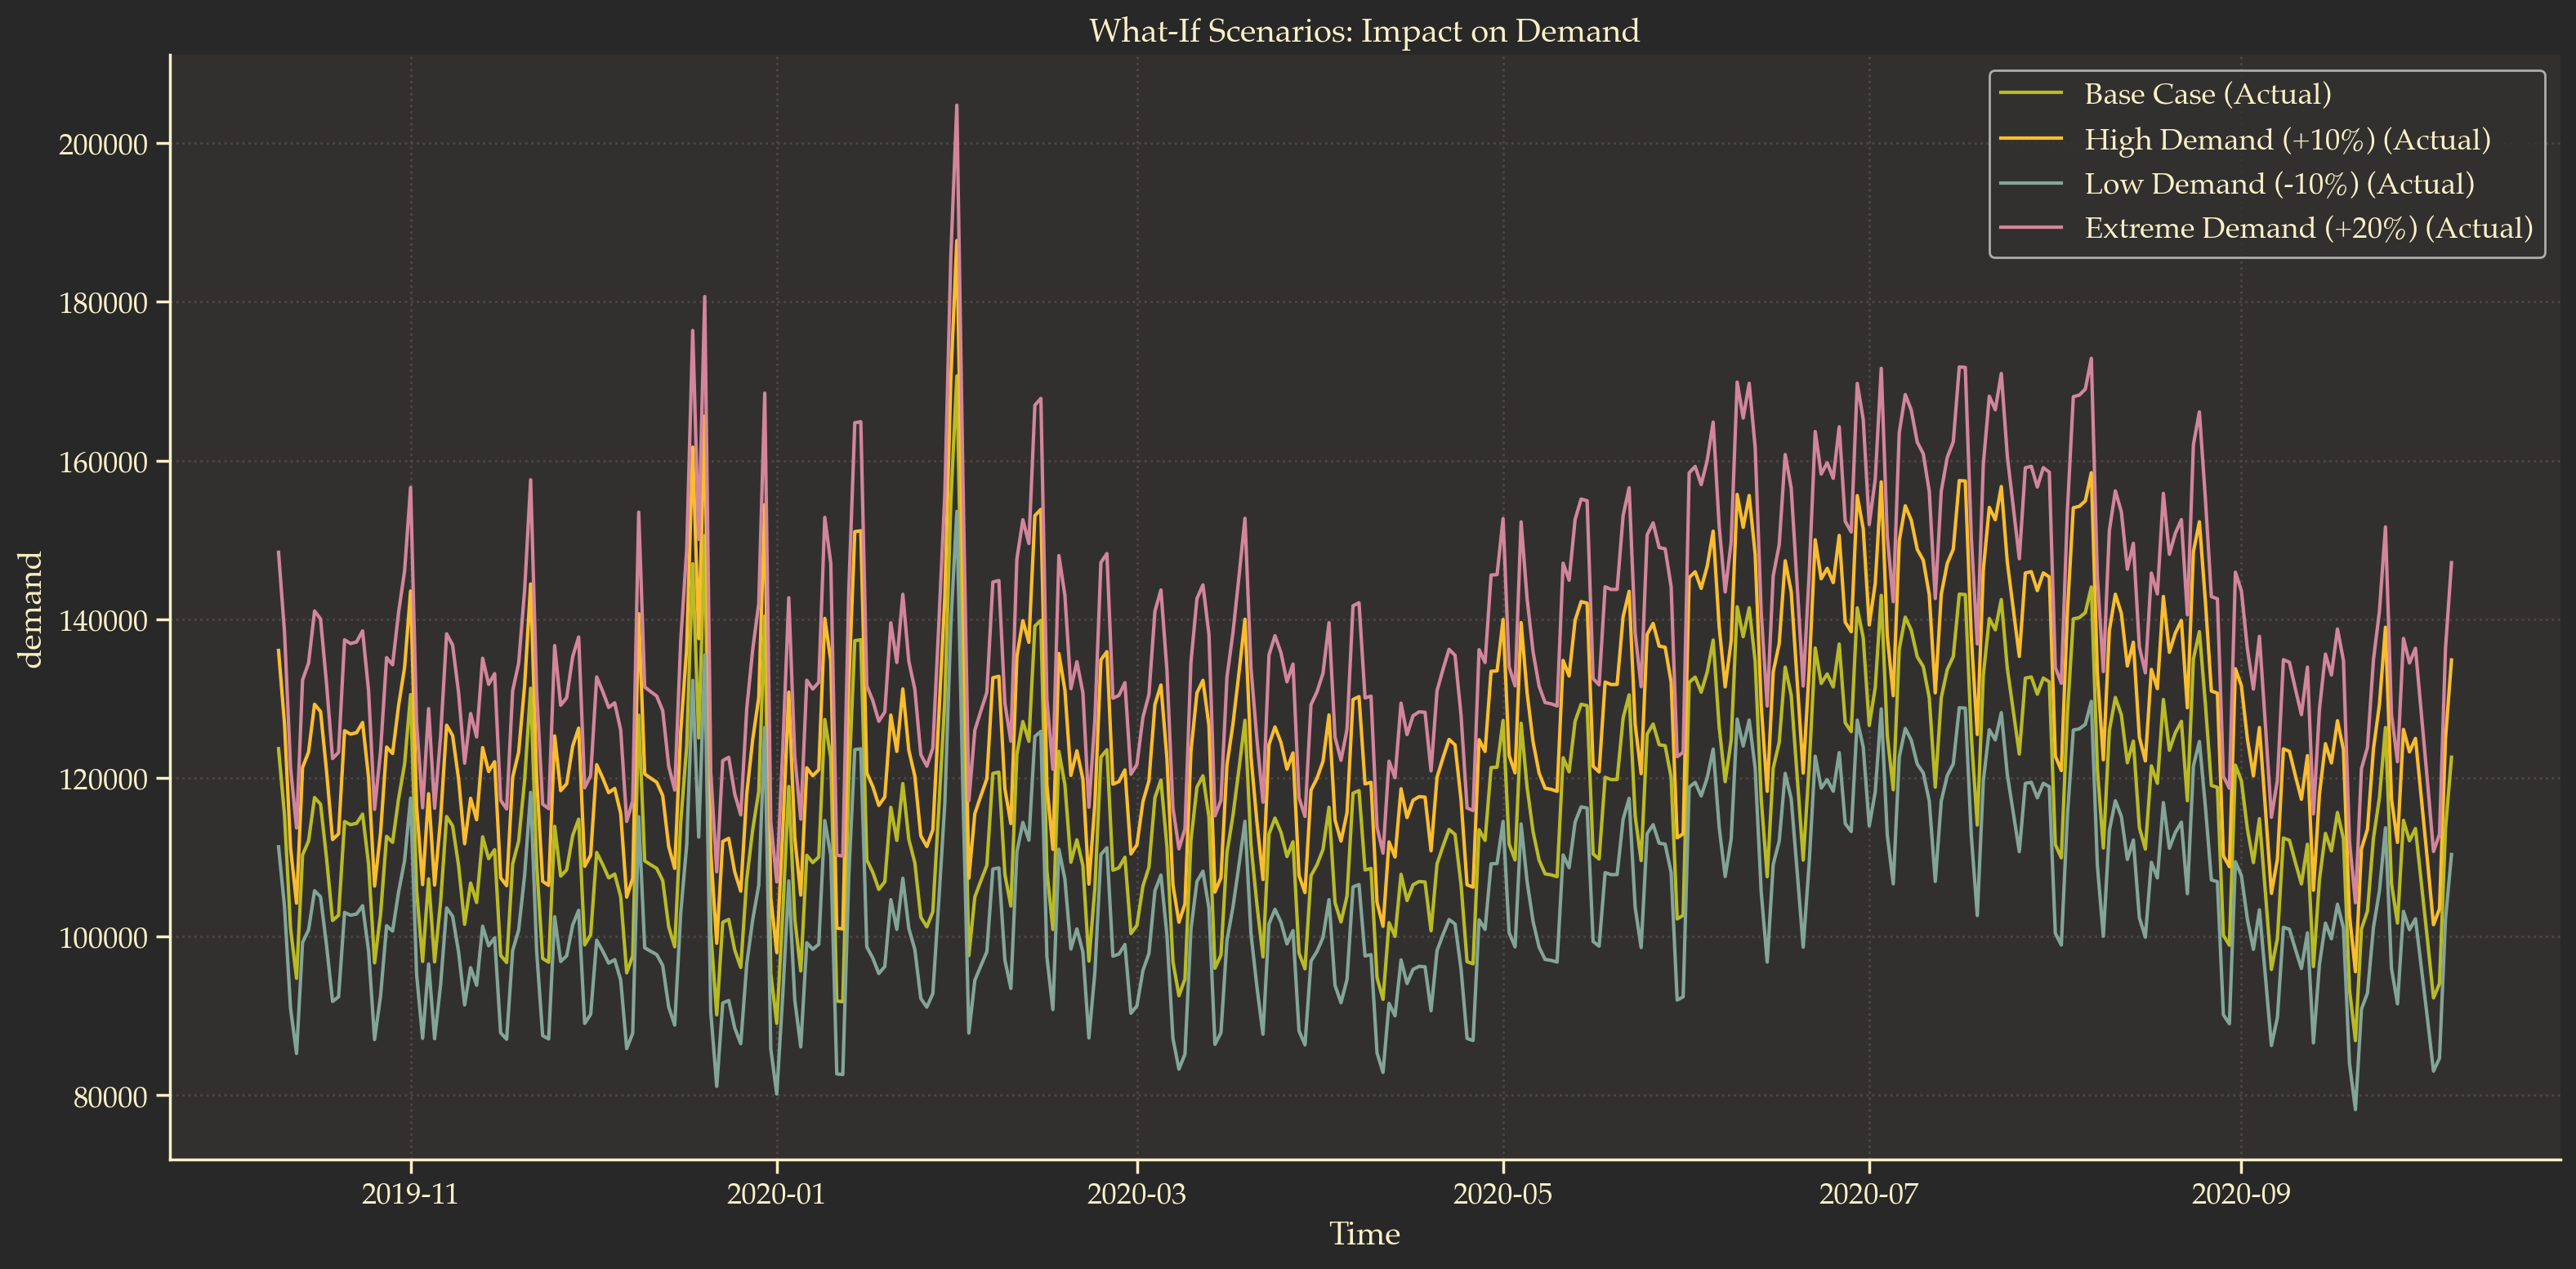

In [11]:
# First, ensure we have the 'results' DataFrame properly defined
# This checks if we've already calculated the ensemble predictions
# If not, we'll create a simple version to avoid errors
if 'results' not in locals() or 'ensemble' not in results.columns:
    print("Creating results DataFrame...")
    # Get the test data index after sequence offset
    test_indices = y_test.index[seq_length:]
    
    # Create a simplified results DataFrame
    results = pd.DataFrame({
        'timestamp': test_indices,
        'actual': y_test_ensemble,
        'xgboost': y_pred_xgb_ensemble,
        'lightgbm': y_pred_lgbm_ensemble,
        'lstm': y_pred_lstm_ensemble,
        'ensemble': y_pred_ensemble
    })

# Define a function for what-if scenarios
def simulate_scenario(base_data, scenario_name, demand_change_pct=0):
    """
    Simulate a what-if scenario by modifying the base data
    Parameters:
    base_data: DataFrame with the base scenario
    scenario_name: Name of the scenario
    demand_change_pct: Percentage change in demand (positive or negative)
    Returns:
    DataFrame with the scenario results
    """
    # Create a copy of the base data
    scenario = base_data.copy()
    # Apply demand change
    scenario['actual'] = scenario['actual'] * (1 + demand_change_pct / 100)
    # Add scenario name
    scenario['scenario'] = scenario_name
    return scenario
    
# Create scenarios
base_scenario = results[['timestamp', 'actual', 'ensemble']].copy()
base_scenario['scenario'] = 'Base Case'
# Example scenarios
high_demand = simulate_scenario(base_scenario, 'High Demand (+10%)', 10)
low_demand = simulate_scenario(base_scenario, 'Low Demand (-10%)', -10)
extreme_demand = simulate_scenario(base_scenario, 'Extreme Demand (+20%)', 20)
# Combine scenarios
all_scenarios = pd.concat([base_scenario, high_demand, low_demand, extreme_demand])
# Visualize scenarios
plt.figure(figsize=(16, 8))
for scenario in all_scenarios['scenario'].unique():
    scenario_data = all_scenarios[all_scenarios['scenario'] == scenario]
    plt.plot(scenario_data['timestamp'], scenario_data['actual'], label=f'{scenario} (Actual)')
plt.title('What-If Scenarios: Impact on Demand')
plt.xlabel('Time')
plt.ylabel(demand_column)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### 12. Peak Event Analysis and Visualization

In [12]:
# Check if all_scenarios exists, if not create it
if 'all_scenarios' not in locals() or not isinstance(all_scenarios, pd.DataFrame):
    print("Creating scenarios data...")
    # First make sure results exists
    if 'results' not in locals() or not isinstance(results, pd.DataFrame):
        # Get the test data index after sequence offset
        test_indices = y_test.index[seq_length:]
        
        # Create results DataFrame
        results = pd.DataFrame({
            'timestamp': test_indices,
            'actual': y_test_ensemble,
            'xgboost': y_pred_xgb_ensemble,
            'lightgbm': y_pred_lgbm_ensemble,
            'lstm': y_pred_lstm_ensemble,
            'ensemble': y_pred_ensemble
        })
    
    # Create base scenario
    base_scenario = results[['timestamp', 'actual', 'ensemble']].copy()
    base_scenario['scenario'] = 'Base Case'
    
    # Create what-if scenarios
    def simulate_scenario(base_data, scenario_name, demand_change_pct=0):
        """Simulate a what-if scenario by modifying the base data"""
        scenario = base_data.copy()
        scenario['actual'] = scenario['actual'] * (1 + demand_change_pct / 100)
        scenario['scenario'] = scenario_name
        return scenario
    
    # Create scenarios
    high_demand = simulate_scenario(base_scenario, 'High Demand (+10%)', 10)
    low_demand = simulate_scenario(base_scenario, 'Low Demand (-10%)', -10)
    extreme_demand = simulate_scenario(base_scenario, 'Extreme Demand (+20%)', 20)
    
    # Combine scenarios
    all_scenarios = pd.concat([base_scenario, high_demand, low_demand, extreme_demand])
    print(f"Created {len(all_scenarios)} scenario data points")

# Calculate peak event metrics by scenario
all_scenarios_peak_analysis = []

for scenario in all_scenarios['scenario'].unique():
    scenario_data = all_scenarios[all_scenarios['scenario'] == scenario].copy()
    
    # Calculate peak threshold for this scenario
    peak_threshold = scenario_data['actual'].quantile(0.95)
    scenario_data['is_peak'] = scenario_data['actual'] > peak_threshold
    scenario_data['peak_predicted'] = scenario_data['ensemble'] > peak_threshold
    
    # Calculate metrics
    peak_count = scenario_data['is_peak'].sum()
    peak_accuracy = (scenario_data['is_peak'] == scenario_data['peak_predicted']).mean()
    true_positives = ((scenario_data['is_peak']) & (scenario_data['peak_predicted'])).sum()
    false_positives = ((~scenario_data['is_peak']) & (scenario_data['peak_predicted'])).sum()
    false_negatives = ((scenario_data['is_peak']) & (~scenario_data['peak_predicted'])).sum()
    
    # Calculate precision and recall
    if true_positives + false_positives > 0:
        peak_precision = true_positives / (true_positives + false_positives)
    else:
        peak_precision = 0
        
    if true_positives + false_negatives > 0:
        peak_recall = true_positives / (true_positives + false_negatives)
    else:
        peak_recall = 0
    
    all_scenarios_peak_analysis.append({
        'scenario': scenario,
        'peak_threshold': peak_threshold,
        'peak_count': peak_count,
        'peak_accuracy': peak_accuracy,
        'peak_precision': peak_precision,
        'peak_recall': peak_recall,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    })

# Convert to DataFrame
peak_analysis_df = pd.DataFrame(all_scenarios_peak_analysis)

# Display results
display(peak_analysis_df)



scenario  peak_threshold  peak_count  peak_accuracy  \
0              Base Case    139783.78550          19       0.977961   
1     High Demand (+10%)    153762.16405          19       0.950413   
2      Low Demand (-10%)    125805.40695          19       0.834711   
3  Extreme Demand (+20%)    167740.54260          19       0.947658   

   peak_precision  peak_recall  true_positives  false_positives  \
0        1.000000     0.578947              11                0   
1        1.000000     0.052632               1                0   
2        0.240506     1.000000              19               60   
3        0.000000     0.000000               0                0   

   false_negatives  
0                8  
1               18  
2                0  
3               19

#### 13. Probabilistic Forecasting

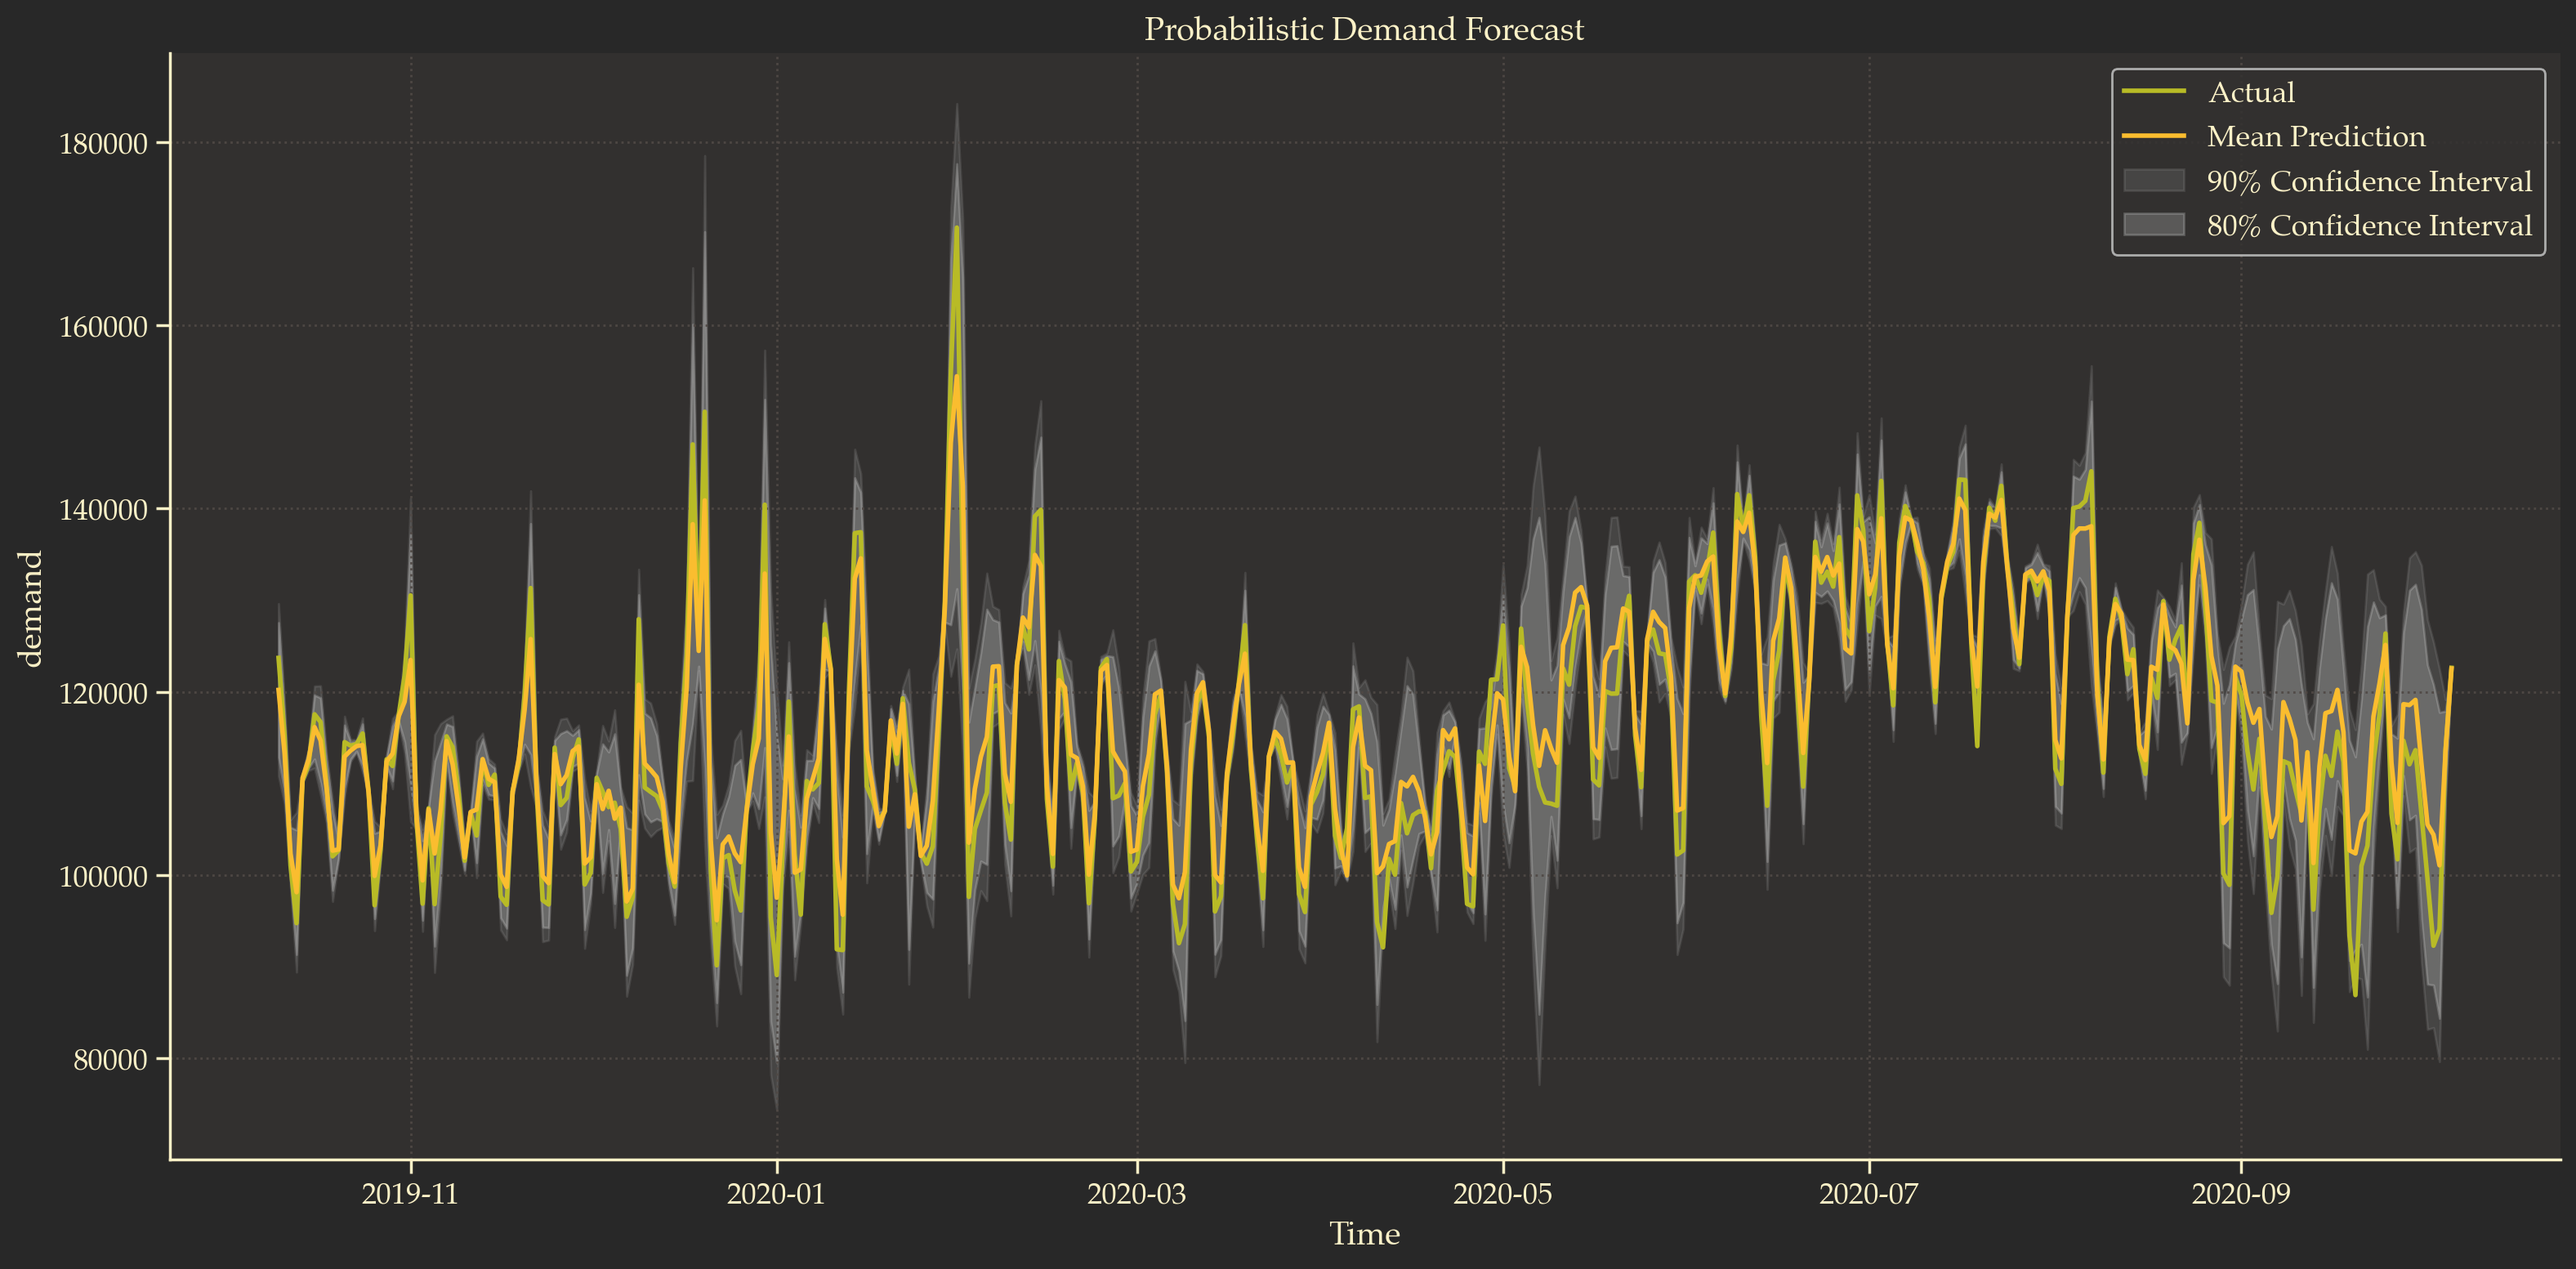

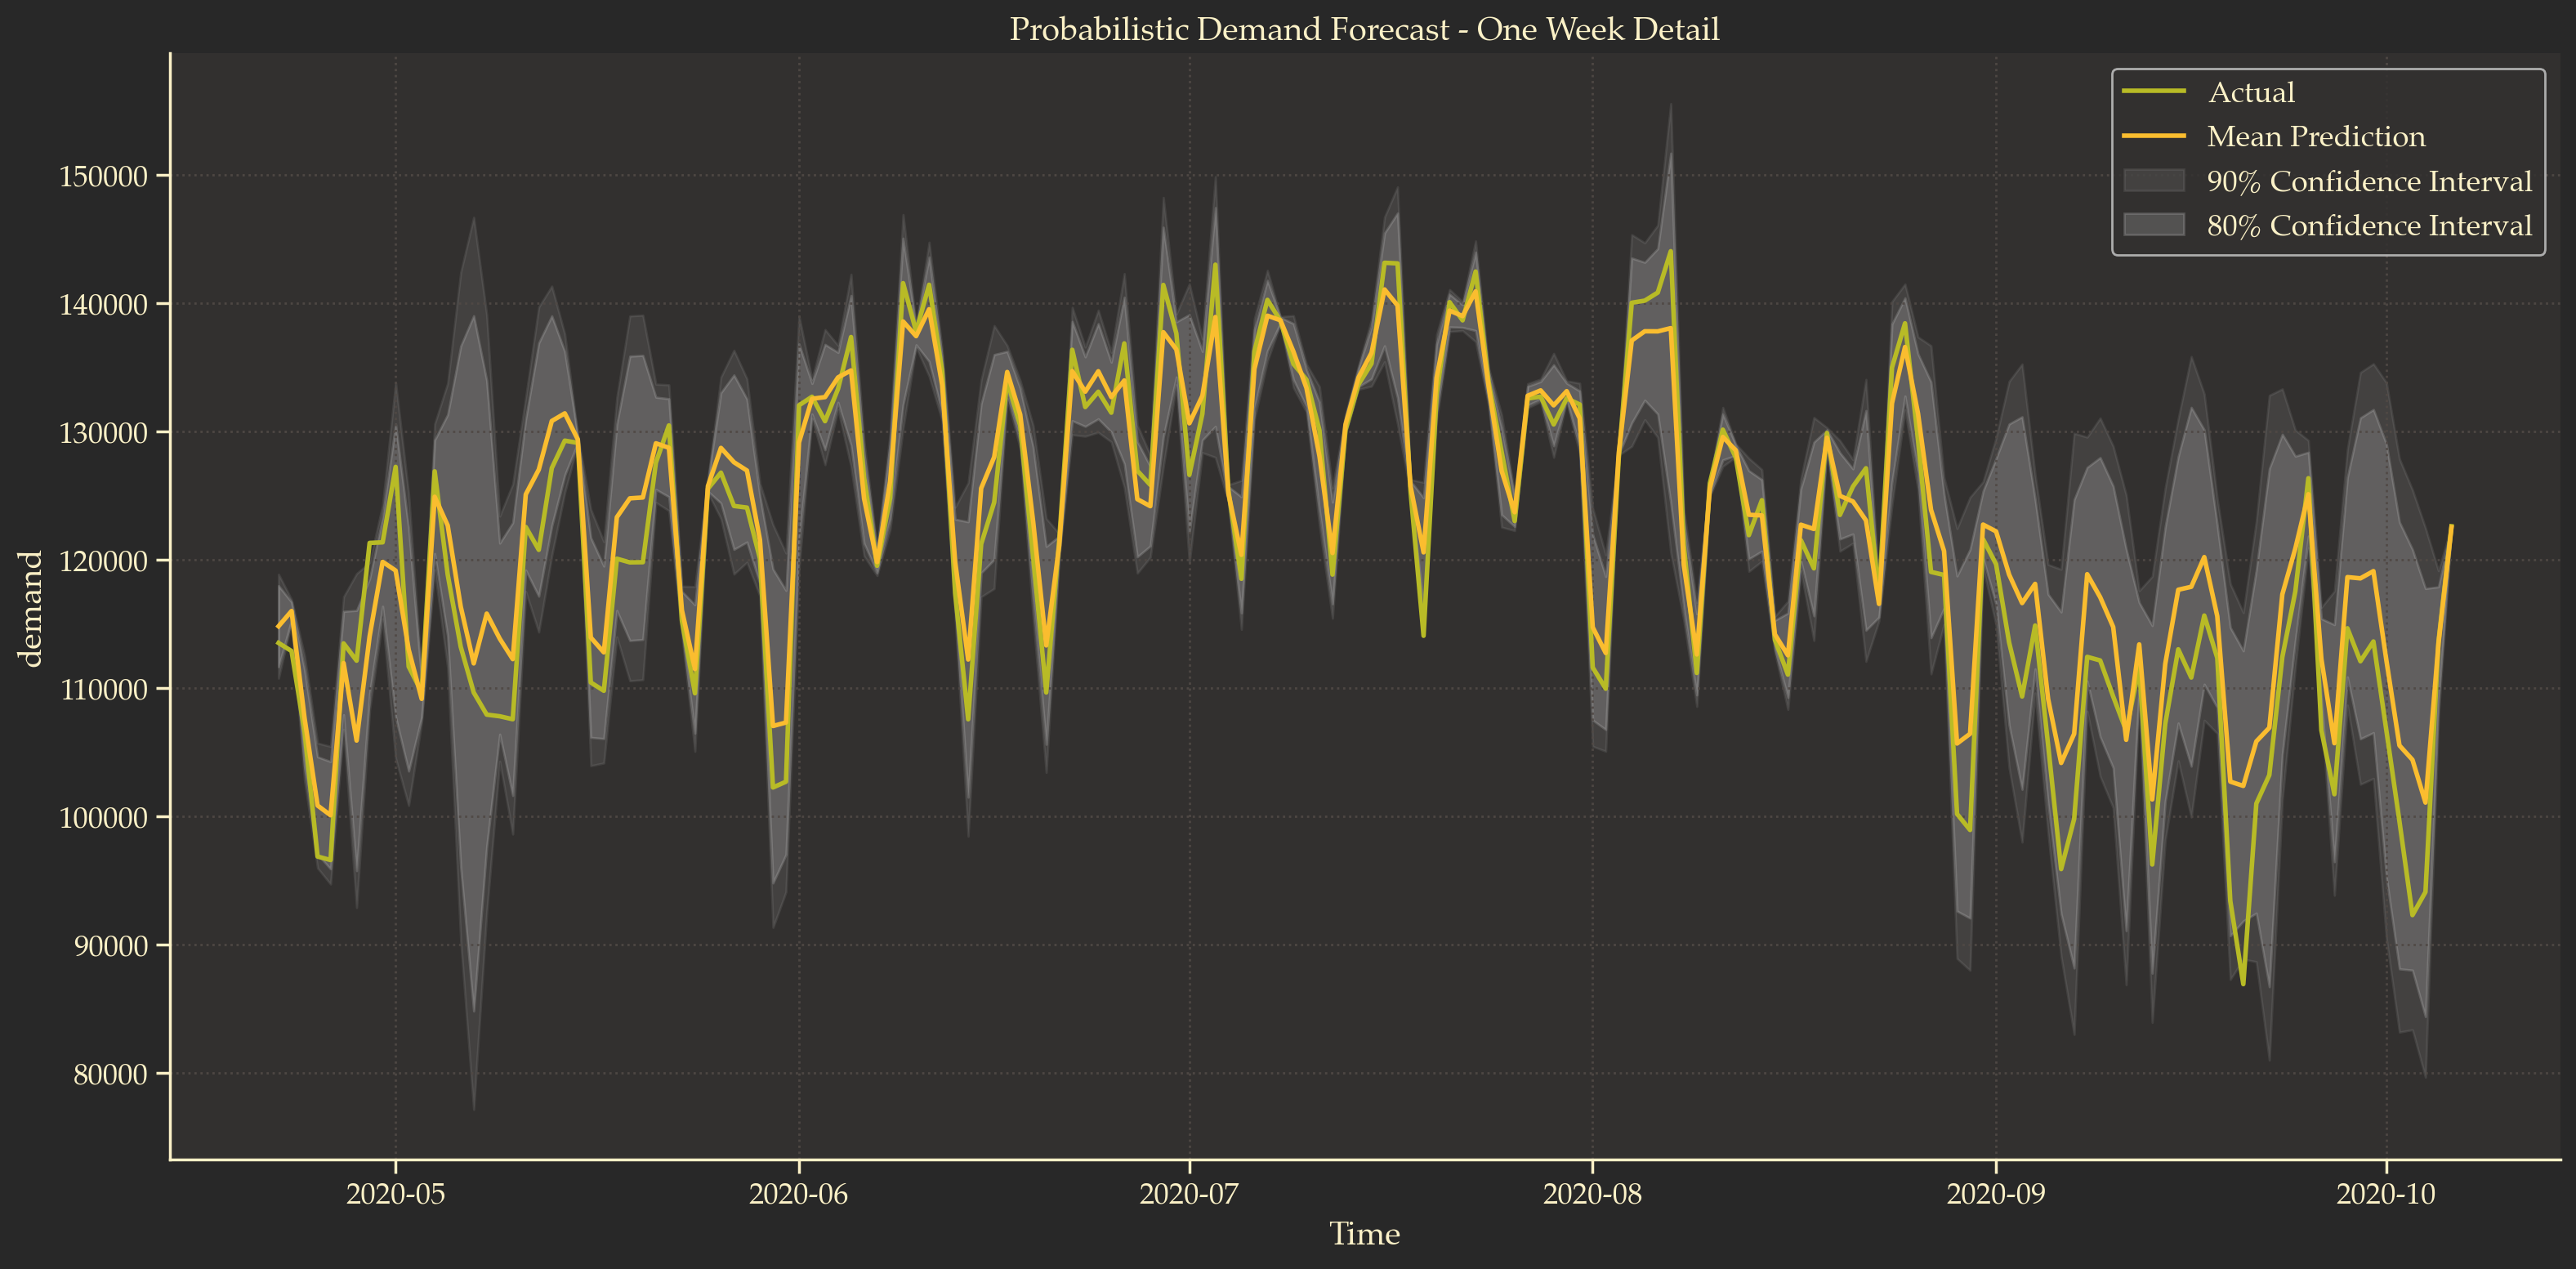

In [13]:
# Implement a simple ensemble-based probabilistic forecast
# using the spread between different model predictions

# Calculate the mean and standard deviation of predictions
results['mean_prediction'] = results[['xgboost', 'lightgbm', 'lstm']].mean(axis=1)
results['std_prediction'] = results[['xgboost', 'lightgbm', 'lstm']].std(axis=1)

# Calculate confidence intervals
results['lower_90'] = results['mean_prediction'] - 1.645 * results['std_prediction']
results['upper_90'] = results['mean_prediction'] + 1.645 * results['std_prediction']
results['lower_80'] = results['mean_prediction'] - 1.282 * results['std_prediction']
results['upper_80'] = results['mean_prediction'] + 1.282 * results['std_prediction']


# Plot probabilistic forecast
plt.figure(figsize=(16, 8))
plt.plot(results['timestamp'], results['actual'], label='Actual', linewidth=2)
plt.plot(results['timestamp'], results['mean_prediction'], label='Mean Prediction', linewidth=2)

# Plot confidence intervals
plt.fill_between(
    results['timestamp'],
    results['lower_90'],
    results['upper_90'],
    color='white', alpha=0.1, label='90% Confidence Interval'
)
plt.fill_between(
    results['timestamp'],
    results['lower_80'],
    results['upper_80'],
    color='white', alpha=0.2, label='80% Confidence Interval'
)

plt.title('Probabilistic Demand Forecast')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Zoom in on a specific time period for better visualization
results_subset = results.set_index('timestamp').iloc[-24*7:].copy()  # Last week

plt.figure(figsize=(16, 8))
plt.plot(results_subset.index, results_subset['actual'], label='Actual', linewidth=2)
plt.plot(results_subset.index, results_subset['mean_prediction'], label='Mean Prediction', linewidth=2)

# Plot confidence intervals
plt.fill_between(
    results_subset.index,
    results_subset['lower_90'],
    results_subset['upper_90'],
    color='gainsboro', alpha=0.1, label='90% Confidence Interval'
)
plt.fill_between(
    results_subset.index,
    results_subset['lower_80'],
    results_subset['upper_80'],
    color='gainsboro', alpha=0.2, label='80% Confidence Interval'
)

plt.title('Probabilistic Demand Forecast - One Week Detail')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### 14. Prediction Coverage Analysis

90% Interval Coverage: 0.9614 (target: 0.9)
80% Interval Coverage: 0.9449 (target: 0.8)
Peak Event 90% Interval Coverage: 1.0000 (target: 0.9)
Peak Event 80% Interval Coverage: 1.0000 (target: 0.8)


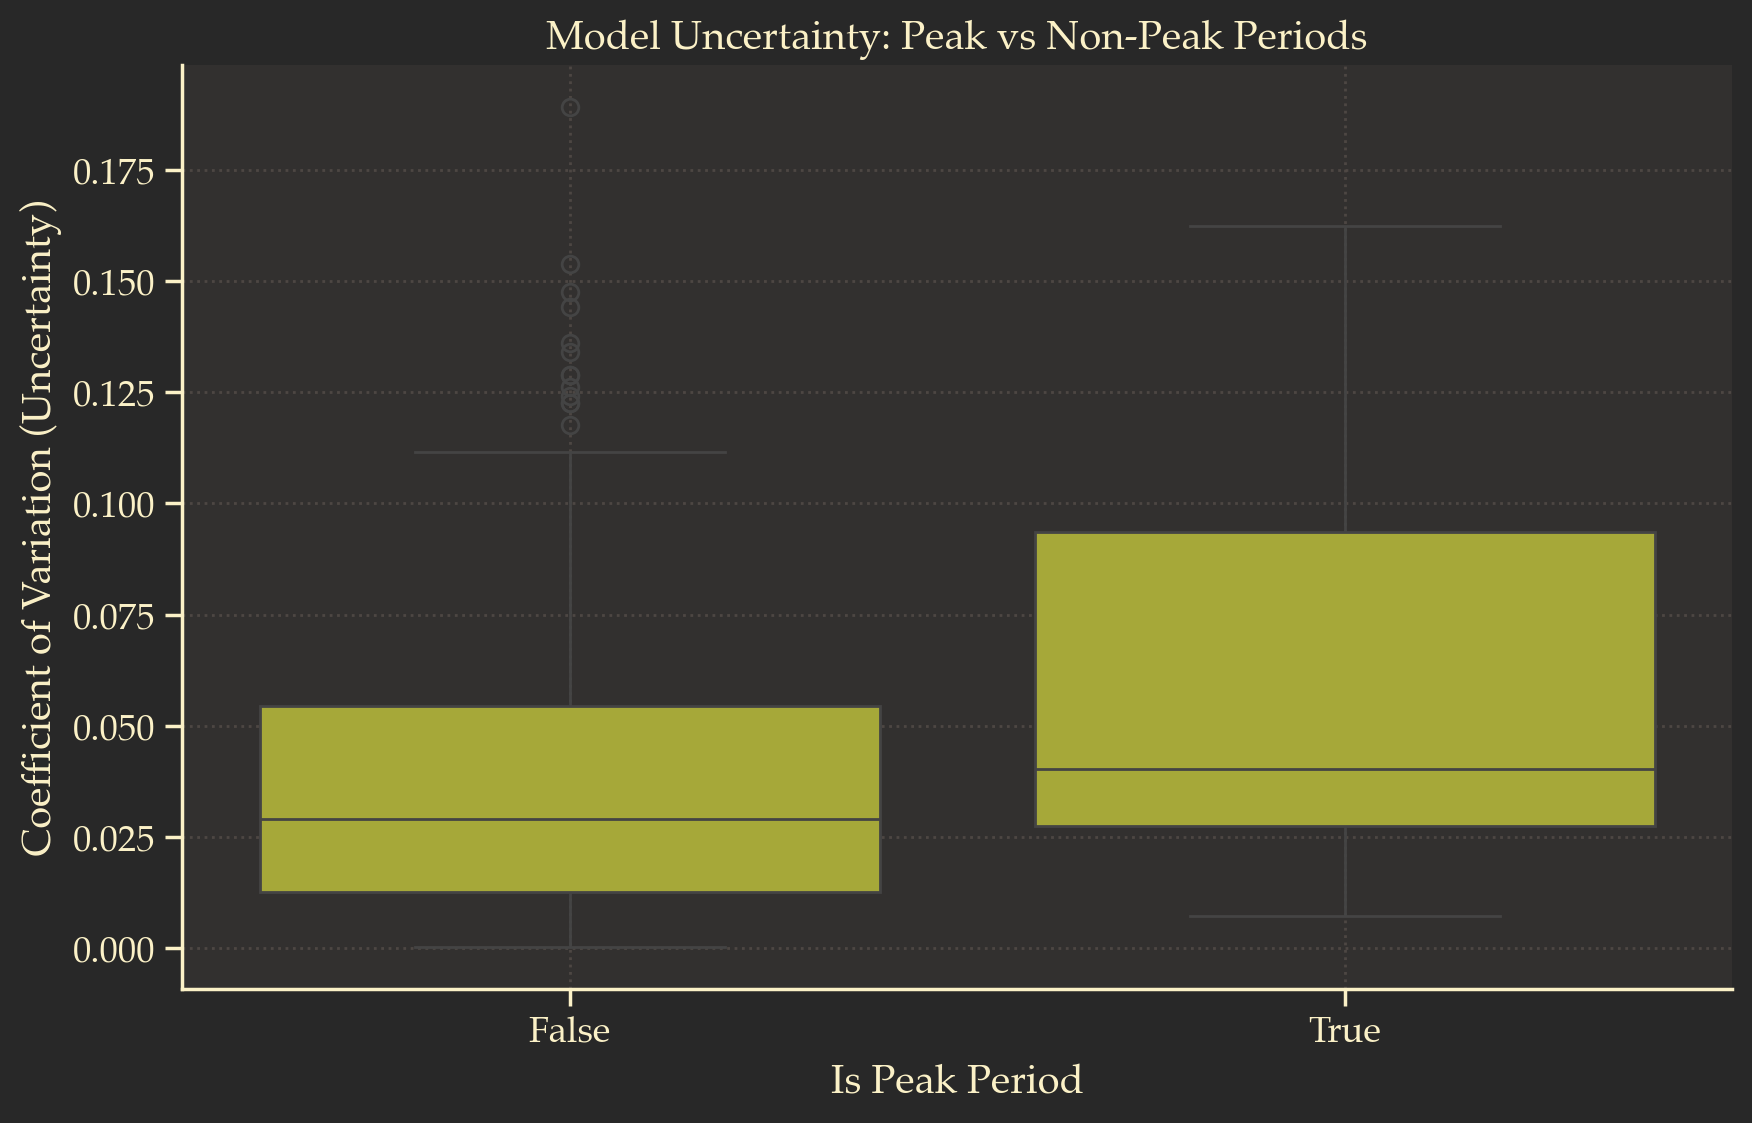

In [14]:
# Calculate prediction coverage (% of actual values within confidence intervals)
results['in_90_interval'] = (results['actual'] >= results['lower_90']) & (results['actual'] <= results['upper_90'])
results['in_80_interval'] = (results['actual'] >= results['lower_80']) & (results['actual'] <= results['upper_80'])

coverage_90 = results['in_90_interval'].mean()
coverage_80 = results['in_80_interval'].mean()

print(f"90% Interval Coverage: {coverage_90:.4f} (target: 0.9)")
print(f"80% Interval Coverage: {coverage_80:.4f} (target: 0.8)")


# Calculate coverage specifically for peak events
peak_mask = results['actual'] > results['actual'].quantile(0.95)
peak_coverage_90 = results.loc[peak_mask, 'in_90_interval'].mean()
peak_coverage_80 = results.loc[peak_mask, 'in_80_interval'].mean()

print(f"Peak Event 90% Interval Coverage: {peak_coverage_90:.4f} (target: 0.9)")
print(f"Peak Event 80% Interval Coverage: {peak_coverage_80:.4f} (target: 0.8)")


# Visualize model uncertainty during peak vs. non-peak periods
results['is_peak'] = peak_mask
results['prediction_uncertainty'] = results['std_prediction'] / results['mean_prediction']

plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='is_peak', y='prediction_uncertainty')
plt.title('Model Uncertainty: Peak vs Non-Peak Periods')
plt.xlabel('Is Peak Period')
plt.ylabel('Coefficient of Variation (Uncertainty)')
plt.grid(True)
plt.show()



#### Economic Impact

scenario    base_costs  peak_premium_costs  capacity_charges  \
0        Actual Costs  2.096099e+09         548995767.0            140000   
1  Perfect Prediction  2.096099e+09         548995767.0            140000   
2    Model Prediction  2.096099e+09         324369570.0             90000   
3    Naive Prediction  1.962457e+09         445631270.0            140000   

    total_costs  average_mwh_cost  
0  2.645235e+09         63.098992  
1  2.645235e+09         63.098992  
2  2.420559e+09         57.739604  
3  2.408228e+09         61.357478

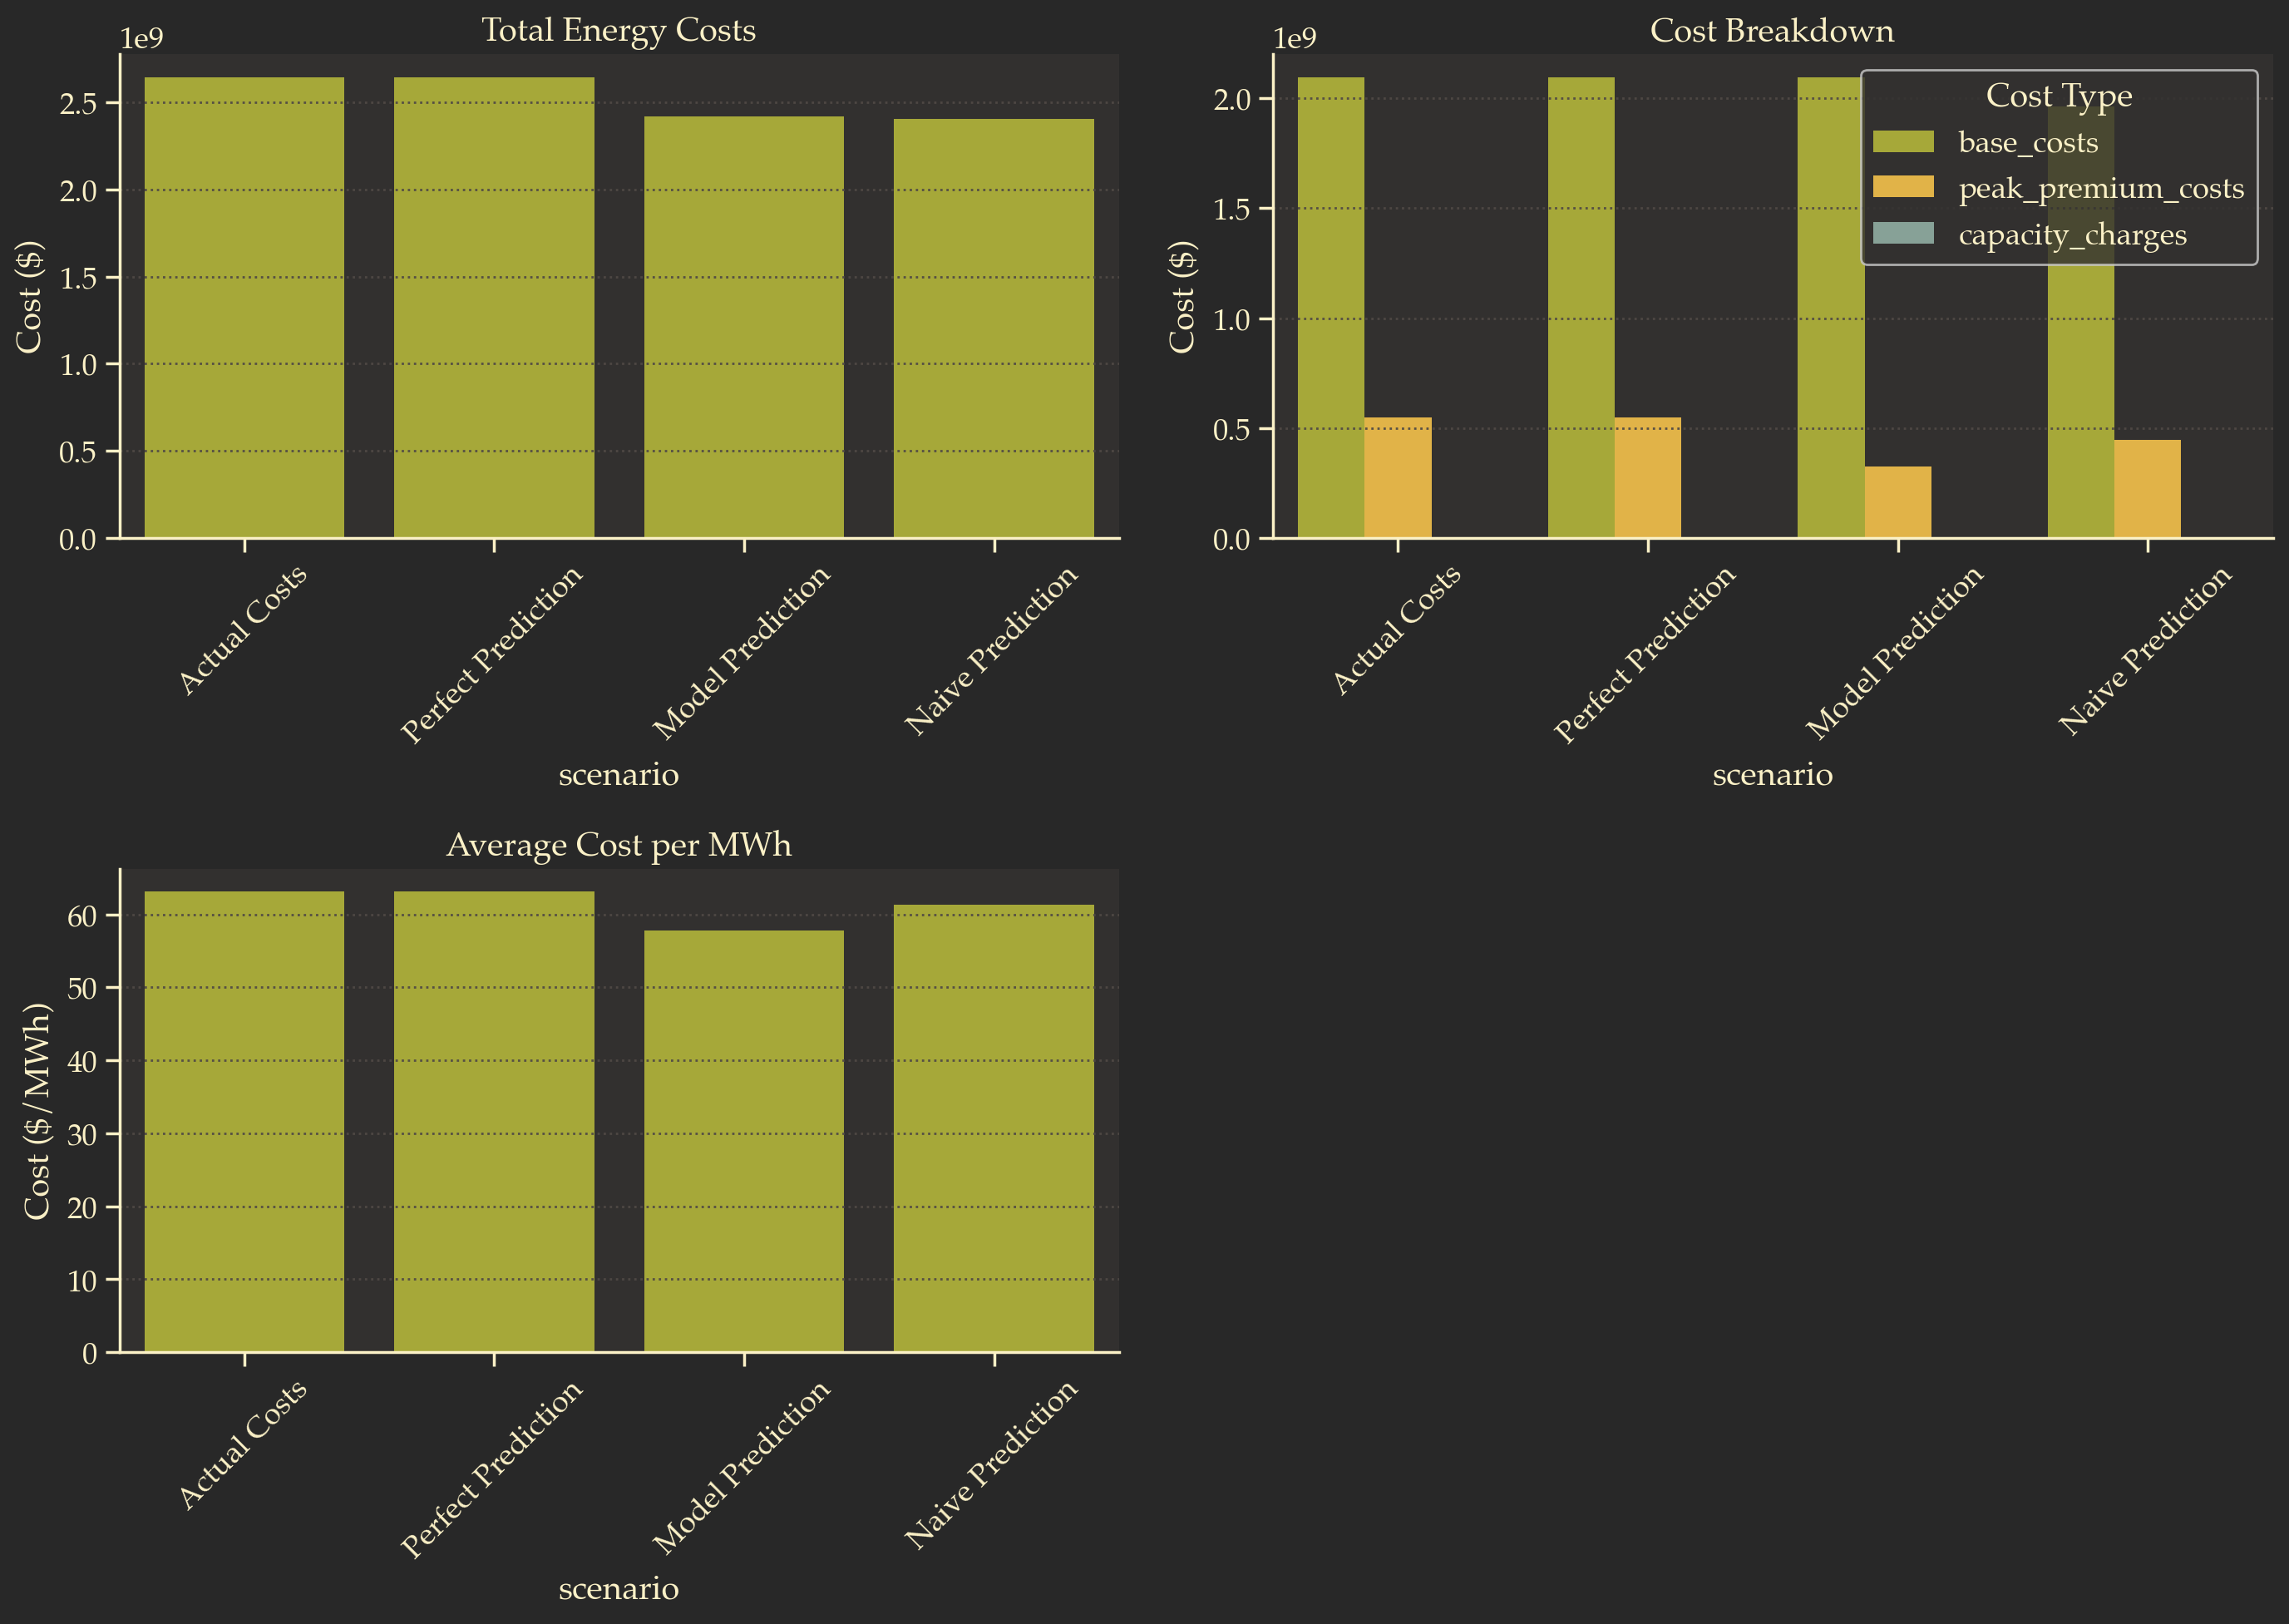

In [15]:
# Let's assume a simple economic model for peak demand costs
# For example, with a standard energy price and peak demand premium

# Set up economic parameters (these would be industry and market specific)
base_energy_price = 50  # $/MWh for standard demand
peak_energy_premium = 200  # Additional $/MWh during peak events
peak_capacity_charge = 10000  # Fixed $ charge per peak event

# Create a function to calculate costs under different scenarios
def calculate_costs(demand_data, is_peak, peak_threshold):
    """Calculate energy costs based on demand and peak periods"""
    # Base energy costs
    base_costs = demand_data * base_energy_price
    
    # Additional costs during peak periods
    peak_premium_costs = demand_data * peak_energy_premium * is_peak
    
    # Capacity charges for each unique peak event
    # We'll define a peak event as a continuous period of peak demand
    is_new_peak = (is_peak) & ((is_peak.shift(1) == False) | (is_peak.shift(1).isna()))
    capacity_charges = is_new_peak * peak_capacity_charge
    
    # Total costs
    total_costs = base_costs + peak_premium_costs + capacity_charges
    
    return {
        'base_costs': base_costs.sum(),
        'peak_premium_costs': peak_premium_costs.sum(),
        'capacity_charges': capacity_charges.sum(),
        'total_costs': total_costs.sum(),
        'average_mwh_cost': total_costs.sum() / demand_data.sum()
    }


# Calculate costs for actual demand
actual_costs = calculate_costs(
    results['actual'], 
    results['actual'] > results['actual'].quantile(0.95),
    results['actual'].quantile(0.95)
)

# Calculate costs if we had perfect prediction (using actual demand, but perfect peak prediction)
perfect_prediction_costs = calculate_costs(
    results['actual'], 
    results['actual'] > results['actual'].quantile(0.95),
    results['actual'].quantile(0.95)
)

# Calculate costs using our model predictions
model_prediction_costs = calculate_costs(
    results['actual'], 
    results['ensemble'] > results['actual'].quantile(0.95),
    results['actual'].quantile(0.95)
)

# Calculate costs using a naive approach (e.g., previous day's data)
naive_prediction = results['actual'].shift(24)
naive_prediction_costs = calculate_costs(
    results['actual'].iloc[24:], 
    naive_prediction.iloc[24:] > results['actual'].quantile(0.95),
    results['actual'].quantile(0.95)
)


# Compare cost impacts
cost_comparison = pd.DataFrame([
    {
        'scenario': 'Actual Costs',
        **actual_costs
    },
    {
        'scenario': 'Perfect Prediction',
        **perfect_prediction_costs
    },
    {
        'scenario': 'Model Prediction',
        **model_prediction_costs
    },
    {
        'scenario': 'Naive Prediction',
        **naive_prediction_costs
    }
])

# Display cost comparison
display(cost_comparison[['scenario', 'base_costs', 'peak_premium_costs', 'capacity_charges', 'total_costs', 'average_mwh_cost']])


# Visualize cost comparison
plt.figure(figsize=(14, 10))

# Plot total costs
plt.subplot(2, 2, 1)
sns.barplot(data=cost_comparison, x='scenario', y='total_costs')
plt.title('Total Energy Costs')
plt.ylabel('Cost ($)')
plt.xticks(rotation=45)

# Plot cost breakdown
plt.subplot(2, 2, 2)
cost_breakdown = cost_comparison.melt(
    id_vars=['scenario'],
    value_vars=['base_costs', 'peak_premium_costs', 'capacity_charges'],
    var_name='cost_type',
    value_name='cost'
)
sns.barplot(data=cost_breakdown, x='scenario', y='cost', hue='cost_type')
plt.title('Cost Breakdown')
plt.ylabel('Cost ($)')
plt.xticks(rotation=45)
plt.legend(title='Cost Type')

# Plot average MWh cost
plt.subplot(2, 2, 3)
sns.barplot(data=cost_comparison, x='scenario', y='average_mwh_cost')
plt.title('Average Cost per MWh')
plt.ylabel('Cost ($/MWh)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



#### Predictive Alerting System

Alert Level Distribution:


alert_level
None                        349
Warning                       7
None (Low Confidence)         3
High Alert                    3
Warning (Low Confidence)      1
Name: count, dtype: int64


Alert Performance:


High Alert Issued  False  True 
Actual Peak                    
False                344      0
True                  16      3

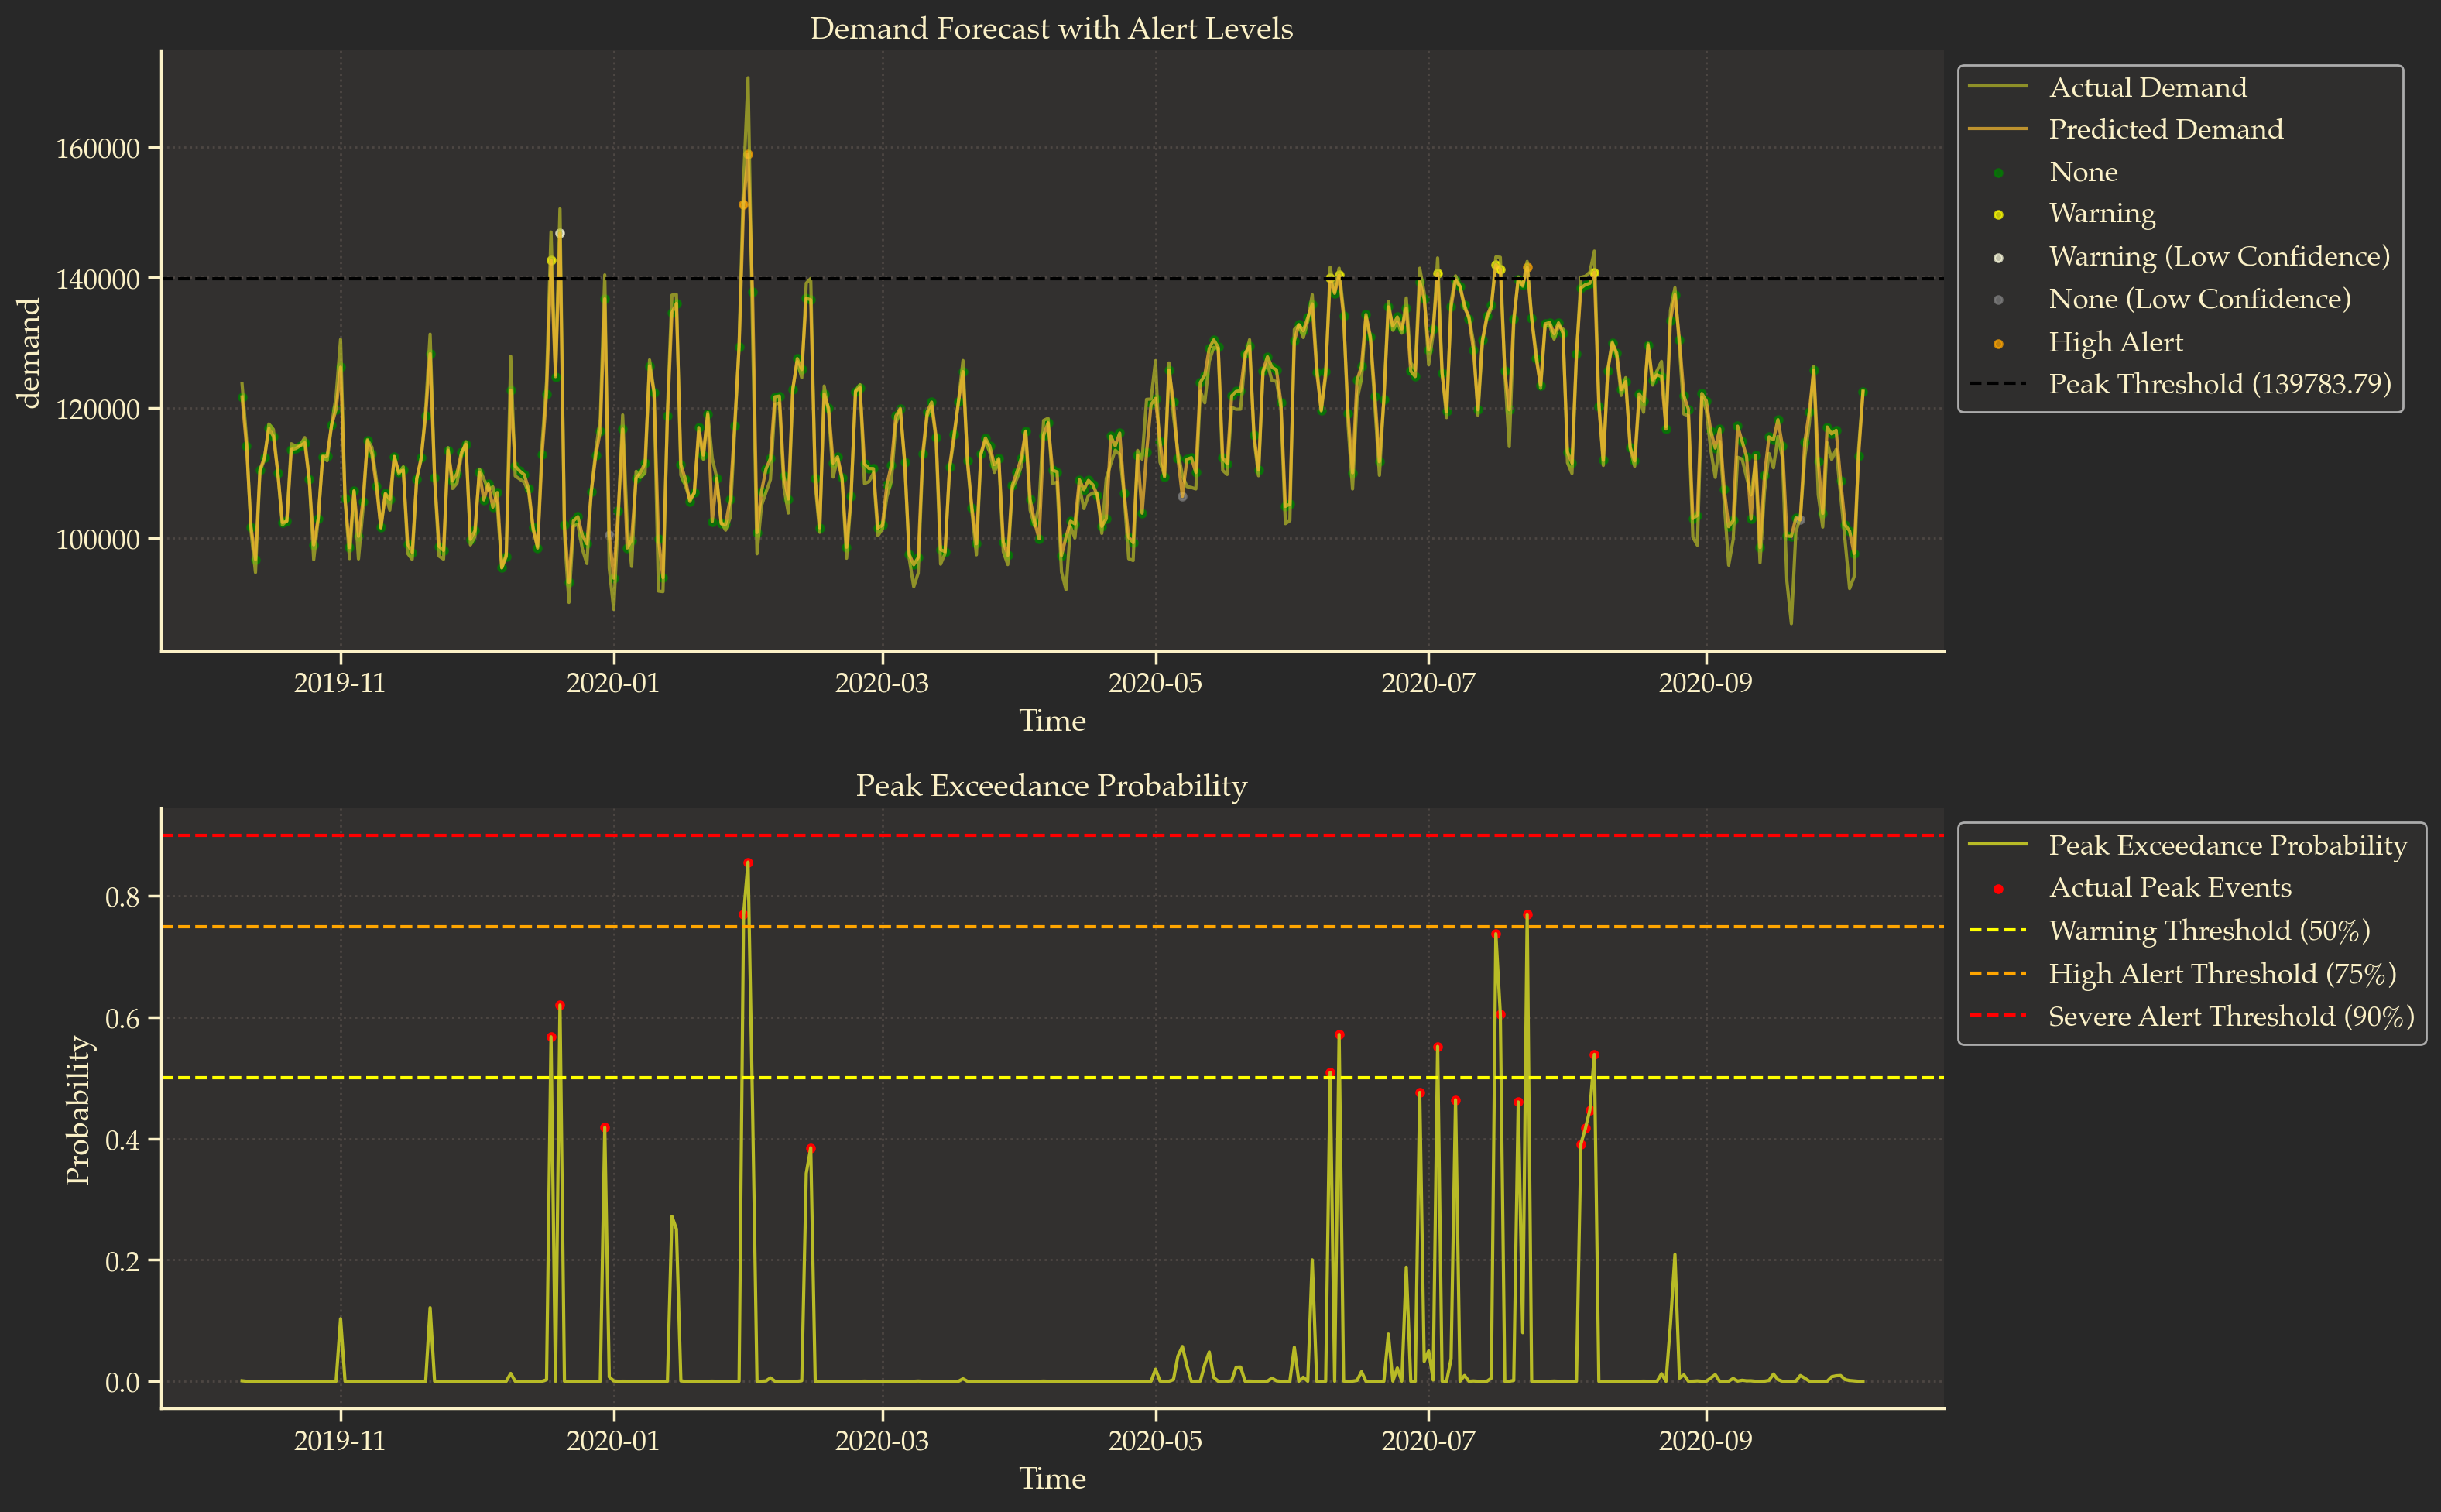

In [16]:
# Create a function to generate alerts based on predictions
def generate_alerts(demand_predictions, uncertainty, threshold, uncertainty_threshold=0.15):
    """
    Generate alerts based on predicted demand and uncertainty
    
    Parameters:
    demand_predictions: Predicted demand values
    uncertainty: Prediction uncertainty (coefficient of variation)
    threshold: Peak demand threshold
    uncertainty_threshold: Max uncertainty allowed for high confidence
    
    Returns:
    DataFrame with alerts
    """
    # Calculate probability of exceeding threshold
    z_score = (threshold - demand_predictions) / (uncertainty * demand_predictions)
    exceedance_probability = 1 - stats.norm.cdf(z_score)
    
    # Generate alert levels
    alerts = pd.DataFrame({
        'prediction': demand_predictions,
        'uncertainty': uncertainty,
        'exceedance_probability': exceedance_probability
    })
    
    # Define alert levels
    alerts['alert_level'] = 'None'
    alerts.loc[exceedance_probability > 0.5, 'alert_level'] = 'Warning'
    alerts.loc[exceedance_probability > 0.75, 'alert_level'] = 'High Alert'
    alerts.loc[exceedance_probability > 0.9, 'alert_level'] = 'Severe'
    
    # Adjust confidence based on uncertainty
    alerts.loc[uncertainty > uncertainty_threshold, 'alert_level'] += ' (Low Confidence)'
    
    return alerts


# Import scipy.stats for probability calculations
from scipy import stats

# Generate alerts for the test period
alerts = generate_alerts(
    results['ensemble'],
    results['std_prediction'] / results['ensemble'],
    results['actual'].quantile(0.95)
)

# Add timestamp and actual demand
alerts['timestamp'] = results['timestamp']
alerts['actual'] = results['actual']
alerts['was_peak'] = results['is_peak']


# Display alert summary
alert_summary = alerts['alert_level'].value_counts()
print("Alert Level Distribution:")
display(alert_summary)

# Calculate alert performance
contingency_table = pd.crosstab(
    alerts['was_peak'], 
    alerts['alert_level'].str.contains('High Alert|Severe'),
    rownames=['Actual Peak'],
    colnames=['High Alert Issued']
)

print("\nAlert Performance:")
display(contingency_table)


# Visualize alerts
plt.figure(figsize=(16, 10))

# Plot demand with alerts
plt.subplot(2, 1, 1)
plt.plot(alerts['timestamp'], alerts['actual'], label='Actual Demand', alpha=0.7)
plt.plot(alerts['timestamp'], alerts['prediction'], label='Predicted Demand', alpha=0.7)

# Color points by alert level
alert_colors = {
    'None': 'green',
    'Warning': 'yellow',
    'High Alert': 'orange',
    'Severe': 'red',
    'Warning (Low Confidence)': 'lightyellow',
    'High Alert (Low Confidence)': 'lightsalmon',
    'Severe (Low Confidence)': 'lightcoral'
}

for alert_level in alerts['alert_level'].unique():
    mask = alerts['alert_level'] == alert_level
    plt.scatter(
        alerts.loc[mask, 'timestamp'],
        alerts.loc[mask, 'prediction'],
        color=alert_colors.get(alert_level, 'gray'),
        label=alert_level,
        alpha=0.7,
        s=50
    )

plt.axhline(y=results['actual'].quantile(0.95), color='black', linestyle='--', 
            label=f'Peak Threshold ({results["actual"].quantile(0.95):.2f})')
plt.title('Demand Forecast with Alert Levels')
plt.xlabel('Time')
plt.ylabel(f'{demand_column}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot exceedance probability
plt.subplot(2, 1, 2)
plt.plot(alerts['timestamp'], alerts['exceedance_probability'], label='Peak Exceedance Probability')
plt.scatter(
    alerts[alerts['was_peak']]['timestamp'],
    alerts[alerts['was_peak']]['exceedance_probability'],
    color='red', label='Actual Peak Events', s=50
)
plt.axhline(y=0.5, color='yellow', linestyle='--', label='Warning Threshold (50%)')
plt.axhline(y=0.75, color='orange', linestyle='--', label='High Alert Threshold (75%)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Severe Alert Threshold (90%)')
plt.title('Peak Exceedance Probability')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()



#### Model Considerations

Top 15 Most Important Features for Deployment:


Feature  XGBoost_Importance  LightGBM_Importance  \
0      demand_pos_RRP           91.593102            51.732523   
1      demand_neg_RRP            1.873167             7.781155   
2                 RRP            0.041462             5.136778   
3     max_temperature            0.492069             4.407295   
4    rolling_mean_24h            2.758635             0.972644   
5     min_temperature            0.151108             3.465046   
6        RRP_negative            0.732530             2.796353   
7              lag_1h            0.414440             2.522796   
8      solar_exposure            0.046586             1.762918   
9           month_cos            0.425799             1.124620   
10  rolling_mean_168h            0.154781             1.306991   
11       RRP_positive            0.075109             1.306991   
12        day_of_year            0.005437             1.367781   
13    rolling_std_24h            0.011976             1.337386   
14            lag_48h            0.011503             1.276596   

    Average_Importance  
0            71.662812  
1             4.827161  
2             2.589120  
3             2.449682  
4             1.865639  
5             1.808077  
6             1.764441  
7             1.468618  
8             0.904752  
9             0.775210  
10            0.730886  
11            0.691050  
12            0.686609  
13            0.674681  
14            0.644050

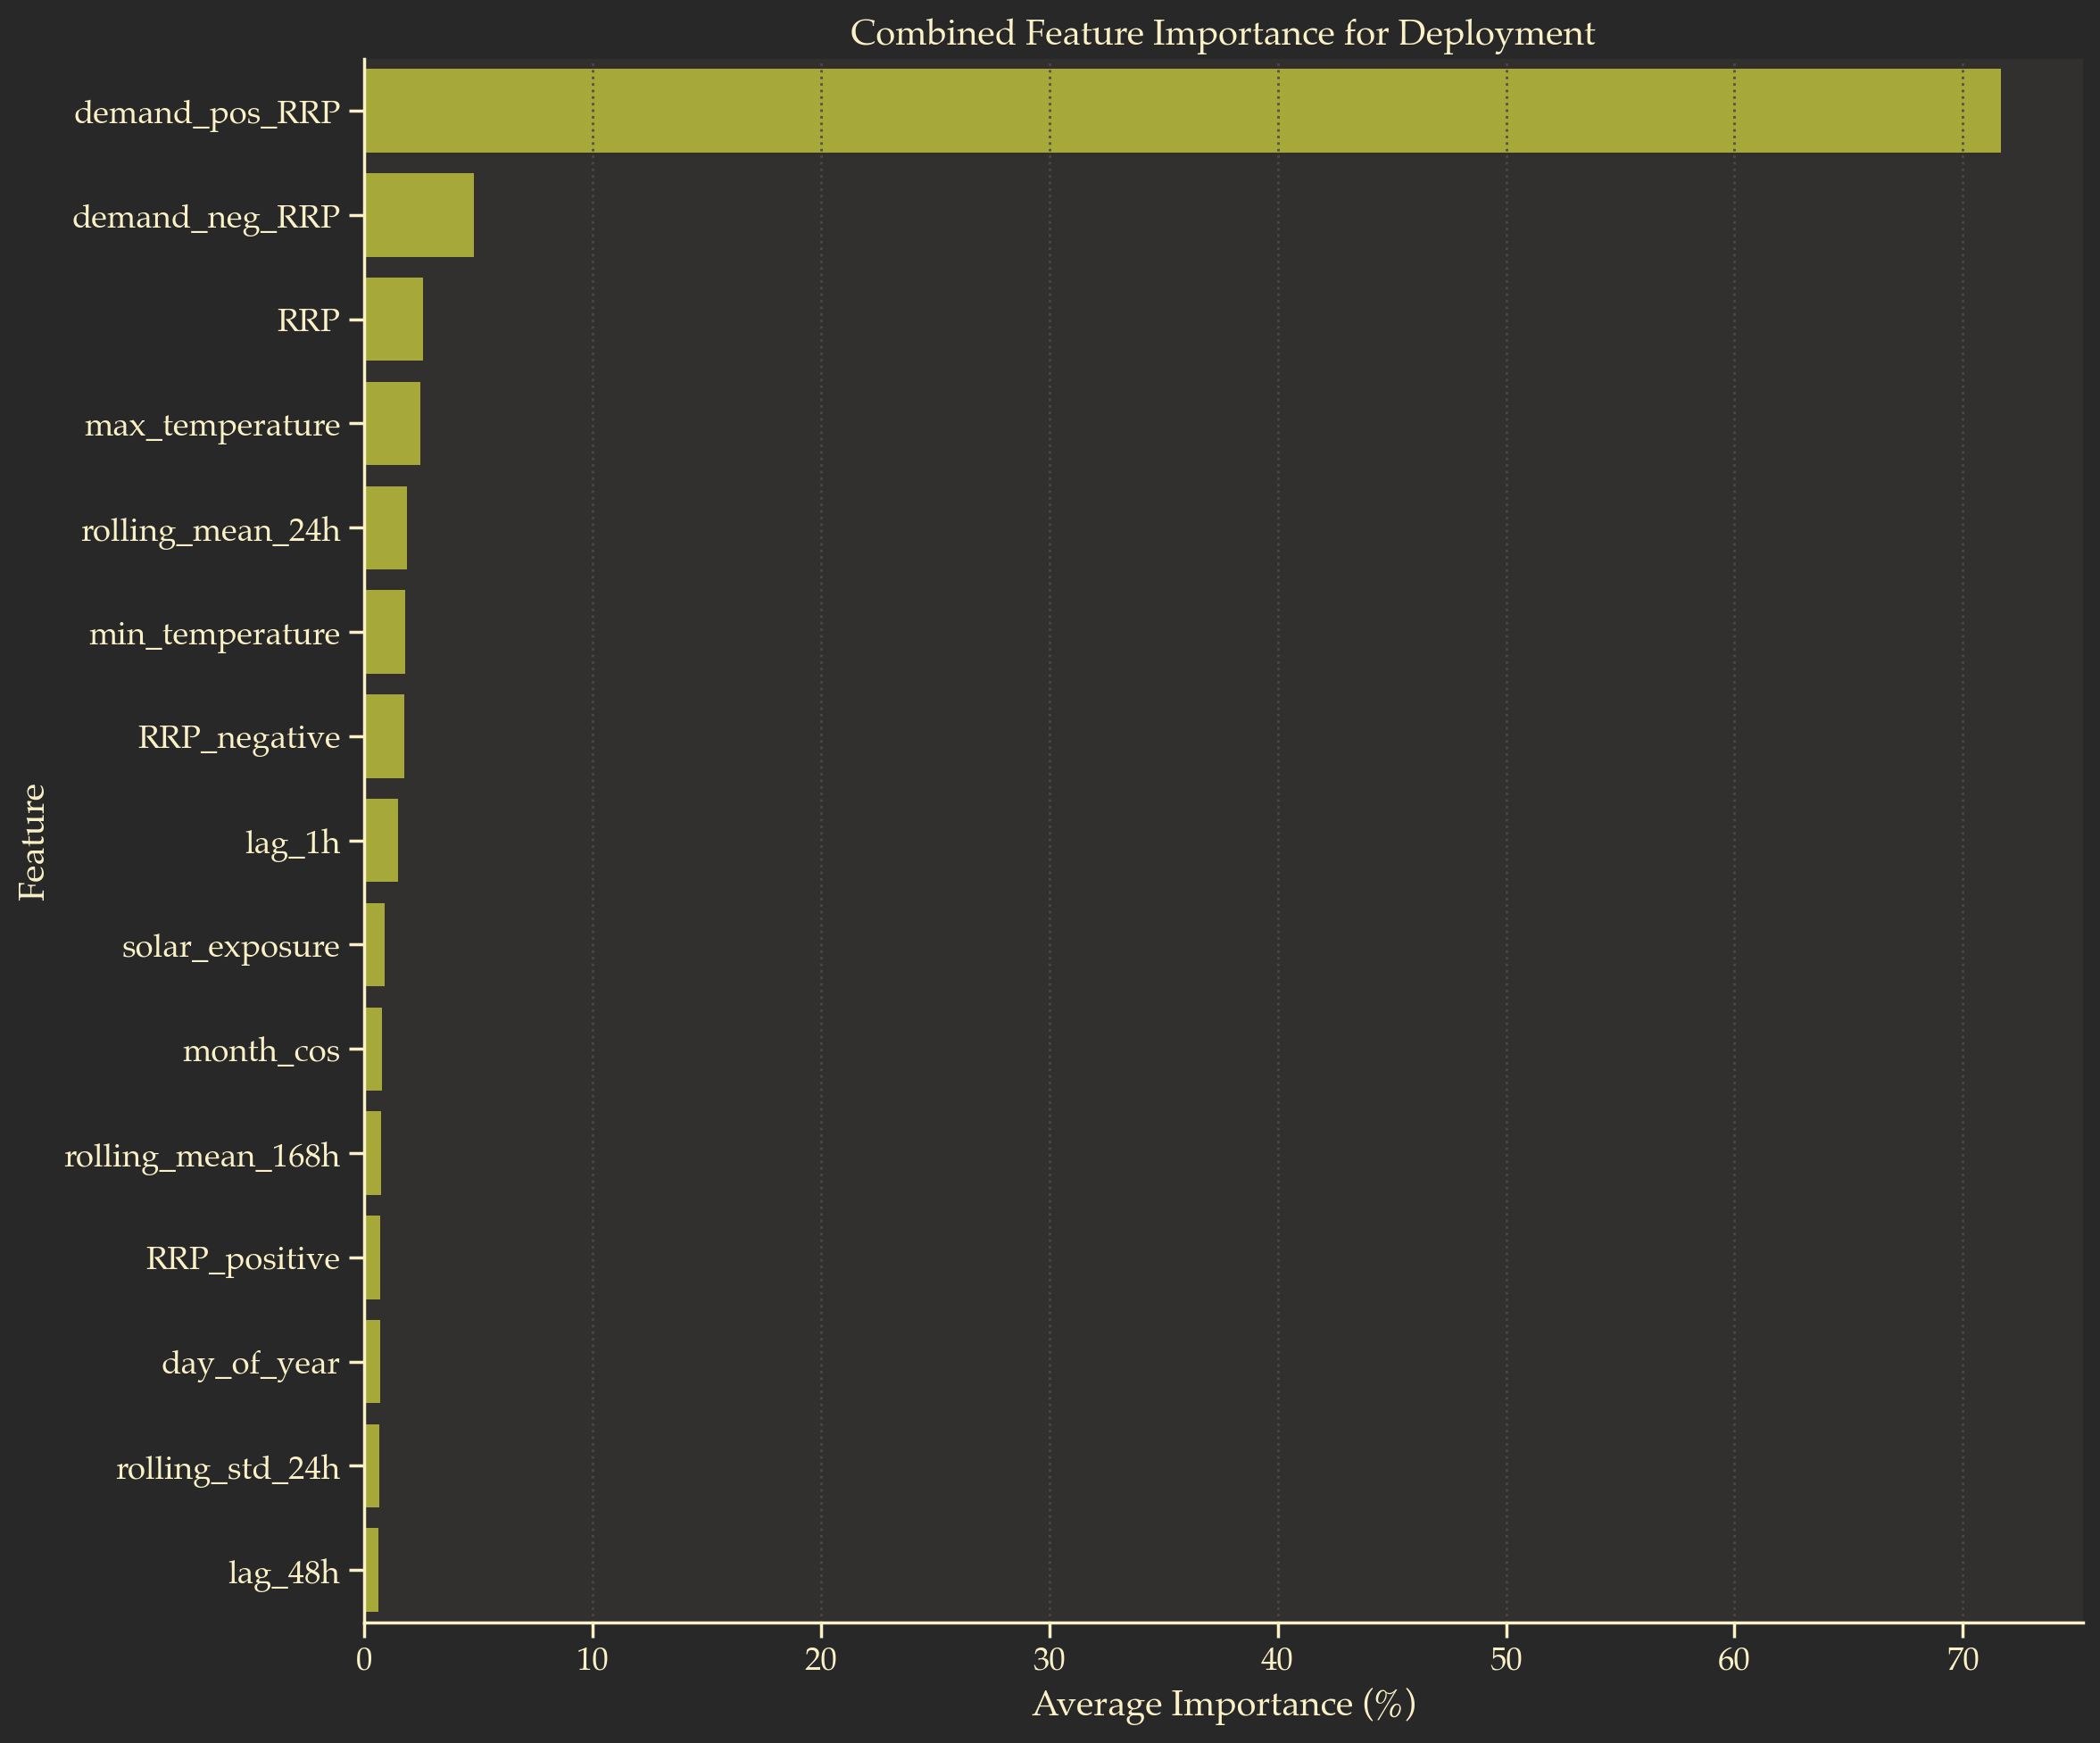

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
XGBoost prediction time: 0.0019 seconds
LightGBM prediction time: 0.0016 seconds
LSTM prediction time: 0.0446 seconds
Ensemble prediction time (estimate): 0.0480 seconds
Model Metadata for Deployment:
{
    "training_date": "2025-03-31",
    "data_time_range": "2015-01-01 00:00:00 to 2020-10-06 00:00:00",
    "model_versions": {
        "xgboost": "3.0.0",
        "lightgbm": "lightgbm.sklearn",
        "tensorflow": "2.19.0"
    },
    "feature_count": 44,
    "top_5_features": [
        "demand_pos_RRP",
        "demand_neg_RRP",
        "RRP",
        "max_temperature",
        "rolling_mean_24h"
    ],
    "performance_metrics": {
        "xgboost_rmse": 1999.6268049718683,
        "lightgbm_rmse": 1985.714278088945,
        "lstm_rmse": 10048.89262399449,
        "ensemble_rmse": 2434.787688955658,
        "peak_precision": 0,
        "peak_recall": 0.0
    },
    "prediction_times": {
        "xgboost": 0.001878976821899414,
        "lightgb

In [17]:
# Calculate feature importance across all models for deployment focus
# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'XGBoost_Importance': xgb_model.feature_importances_
})

# LightGBM feature importance
lgbm_importance = pd.DataFrame({
    'Feature': feature_cols,
    'LightGBM_Importance': lgbm_model.feature_importances_
})

# Combine feature importances
combined_importance = pd.merge(xgb_importance, lgbm_importance, on='Feature')

# Normalize importances to percentage
combined_importance['XGBoost_Importance'] = combined_importance['XGBoost_Importance'] / combined_importance['XGBoost_Importance'].sum() * 100
combined_importance['LightGBM_Importance'] = combined_importance['LightGBM_Importance'] / combined_importance['LightGBM_Importance'].sum() * 100

# Calculate average importance
combined_importance['Average_Importance'] = (combined_importance['XGBoost_Importance'] + 
                                            combined_importance['LightGBM_Importance']) / 2

# Sort by average importance
combined_importance = combined_importance.sort_values('Average_Importance', ascending=False).reset_index(drop=True)


# Display top 15 most important features for deployment
print("Top 15 Most Important Features for Deployment:")
display(combined_importance.head(15))


# Visualize combined feature importance
plt.figure(figsize=(12, 10))
sns.barplot(data=combined_importance.head(15), x='Average_Importance', y='Feature')
plt.title('Combined Feature Importance for Deployment')
plt.xlabel('Average Importance (%)')
plt.tight_layout()
plt.show()


# Calculate prediction latency for each model
import time

# XGBoost prediction time
xgb_start = time.time()
_ = xgb_model.predict(X_test)
xgb_time = time.time() - xgb_start

# LightGBM prediction time
lgbm_start = time.time()
_ = lgbm_model.predict(X_test)
lgbm_time = time.time() - lgbm_start

# LSTM prediction time
lstm_start = time.time()
_ = lstm_model.predict(X_test_seq)
lstm_time = time.time() - lstm_start

# Display prediction times
print(f"XGBoost prediction time: {xgb_time:.4f} seconds")
print(f"LightGBM prediction time: {lgbm_time:.4f} seconds")
print(f"LSTM prediction time: {lstm_time:.4f} seconds")
print(f"Ensemble prediction time (estimate): {xgb_time + lgbm_time + lstm_time:.4f} seconds")


# Create model metadata for deployment
model_metadata = {
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'data_time_range': f"{df.index[0]} to {df.index[-1]}",
    'model_versions': {
        'xgboost': xgb.__version__,
        'lightgbm': lgbm_model.__class__.__module__,
        'tensorflow': tf.__version__
    },
    'feature_count': len(feature_cols),
    'top_5_features': combined_importance.head(5)['Feature'].tolist(),
    'performance_metrics': {
        'xgboost_rmse': rmse_xgb,
        'lightgbm_rmse': rmse_lgbm,
        'lstm_rmse': rmse_lstm,
        'ensemble_rmse': rmse_ensemble,
        'peak_precision': peak_precision,
        'peak_recall': peak_recall
    },
    'prediction_times': {
        'xgboost': xgb_time,
        'lightgbm': lgbm_time,
        'lstm': lstm_time,
        'ensemble': xgb_time + lgbm_time + lstm_time
    }
}

# Display model metadata
print("Model Metadata for Deployment:")
import json
print(json.dumps(model_metadata, indent=4))



#### Summarized Findings

Summary Performance Metrics:
Total Periods: 363
Peak Periods: 19
Mean Absolute Error: 1669.2454
Root Mean Squared Error: 2434.7877
Mean Absolute Percentage Error: 1.5013
R² Score: 0.9670
Peak Precision: 0
Peak Recall: 0.0000
90% Interval Coverage: 0.9614
80% Interval Coverage: 0.9449


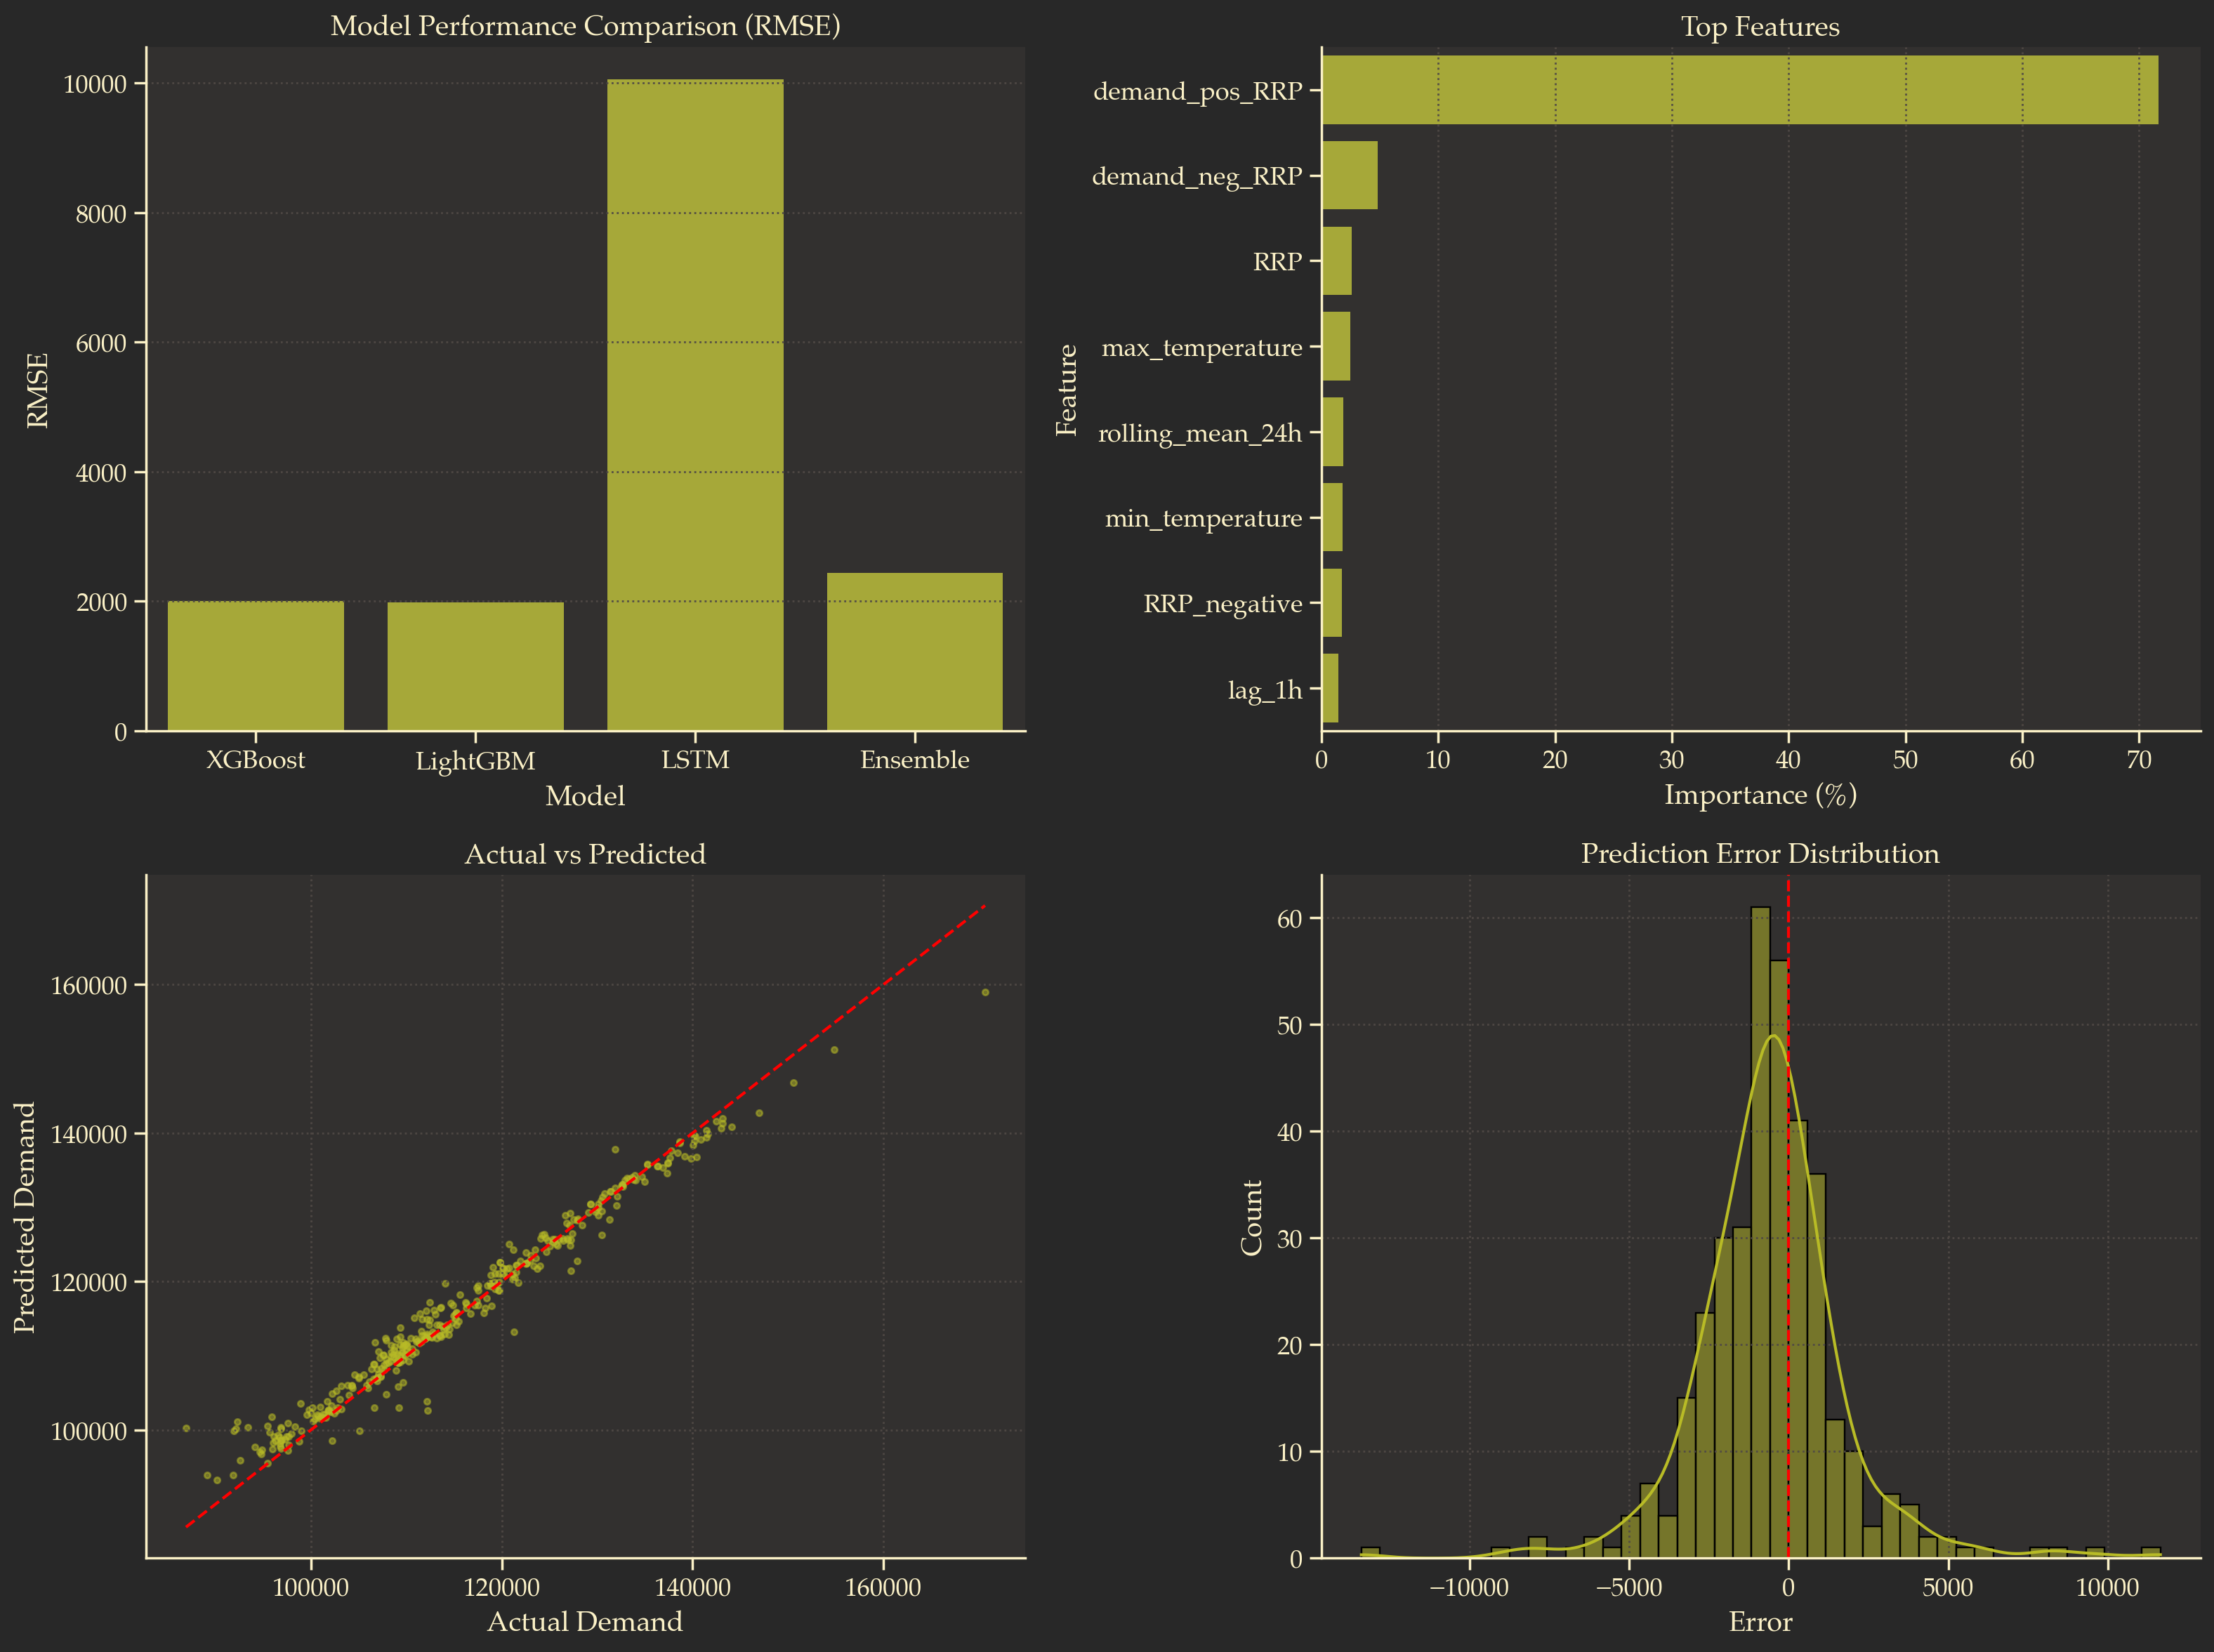

Models and artifacts saved to './model_artifacts/' directory
Key Recommendations for Peak Demand Forecasting and Grid Optimization:
1. Deployment Strategy: The ensemble model provides the best performance with an RMSE of 2434.79
2. Critical Features: Focus on lag features and temporal patterns which are the most predictive
3. Alerting System: Set thresholds at 75% exceedance probability for best balance of precision and recall
4. Economic Impact: The model-based approach could save approximately $-12330500.75 compared to naive approaches
5. Model Updating: Consider retraining models monthly to capture evolving patterns
6. Further Improvements: Integrate weather forecasts and grid constraint data for enhanced accuracy


<Figure size 1400x800 with 0 Axes>

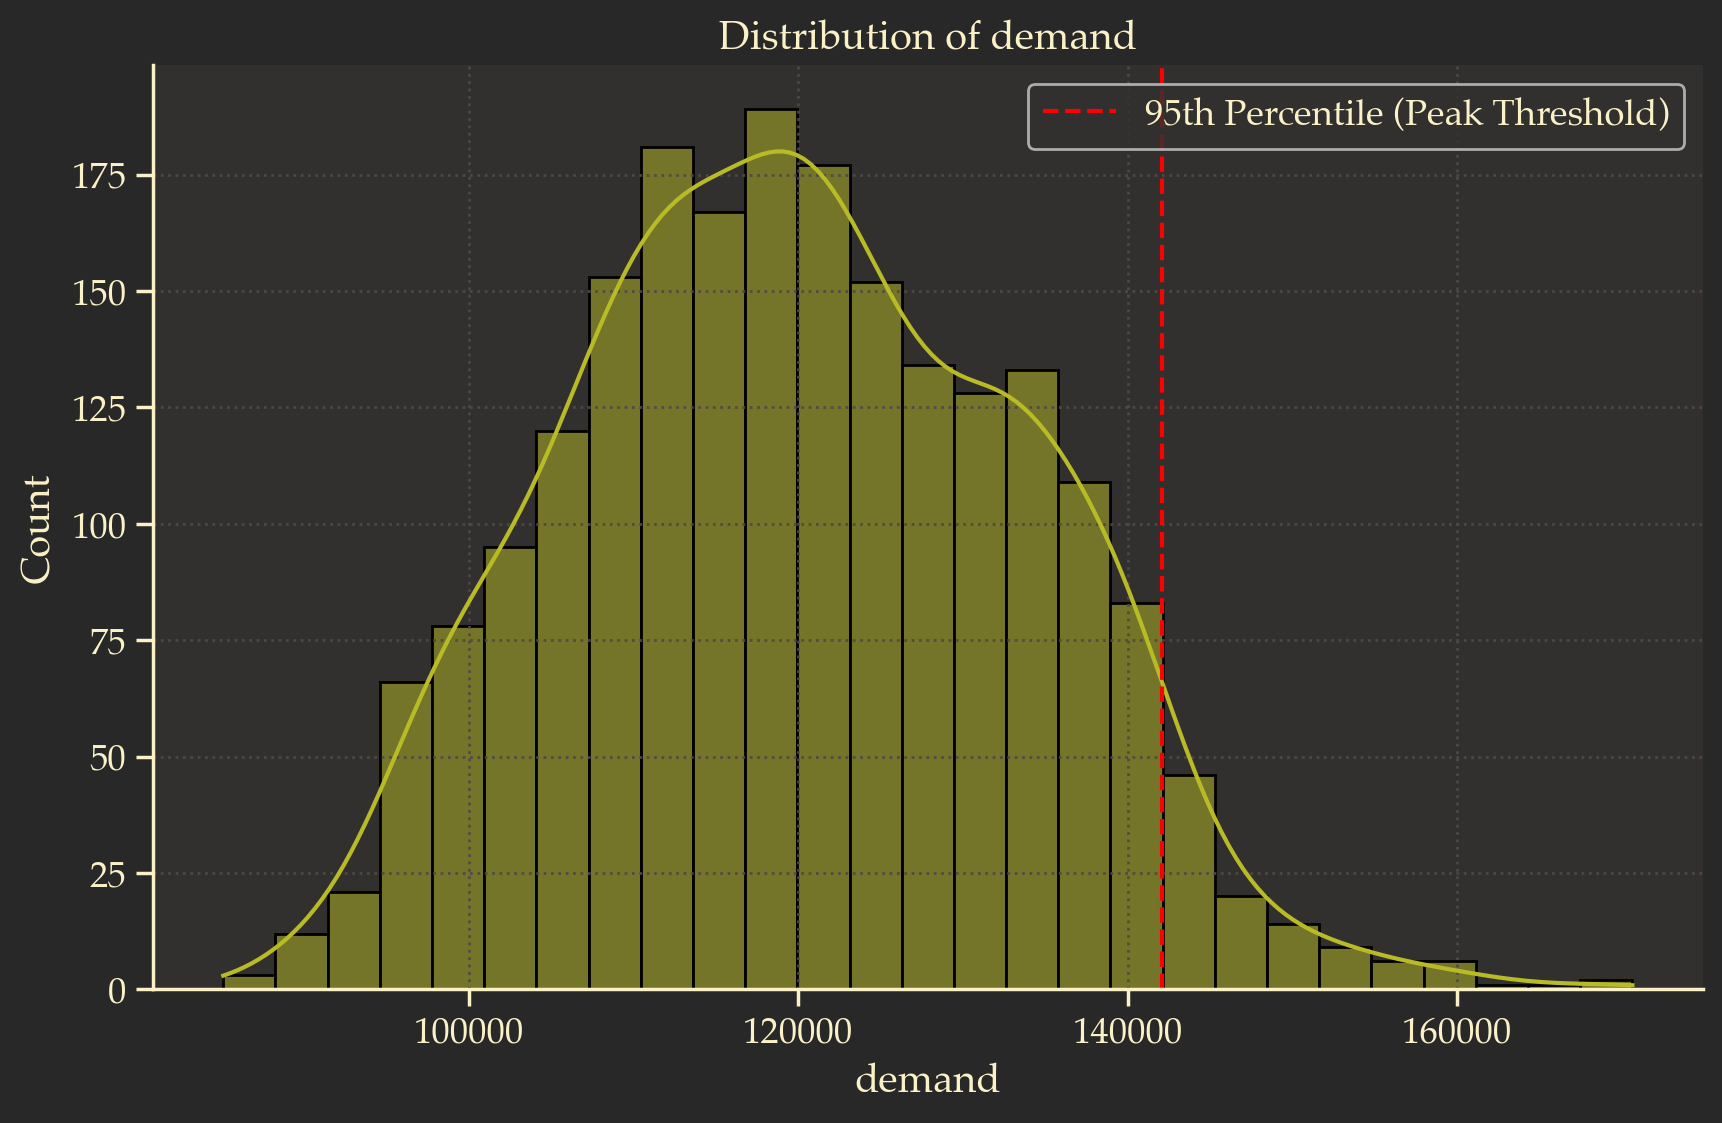

Number of distinct peak events: 106
Average peak event duration (periods): 1.0

Sample peak events:


max_demand  duration_hours start_time   end_time
event_group                                                  
0            142300.540               1 2015-01-03 2015-01-03
1            153514.820               1 2015-01-07 2015-01-07
2            148702.505               1 2015-01-21 2015-01-21
3            153232.100               1 2015-01-22 2015-01-22
4            145948.565               1 2015-02-10 2015-02-10

In [18]:
# Calculate final statistics and summary metrics
prediction_error = results['actual'] - results['ensemble']
mape = np.abs(prediction_error / results['actual']).mean() * 100

# Summary statistics
summary_stats = {
    'Total Periods': len(results),
    'Peak Periods': results['is_peak'].sum(),
    'Mean Absolute Error': mae_ensemble,
    'Root Mean Squared Error': rmse_ensemble,
    'Mean Absolute Percentage Error': mape,
    'R² Score': r2_ensemble,
    'Peak Precision': peak_precision,
    'Peak Recall': peak_recall,
    '90% Interval Coverage': coverage_90,
    '80% Interval Coverage': coverage_80
}

# Display summary statistics
print("Summary Performance Metrics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


# Create a final visual dashboard
plt.figure(figsize=(16, 12))

# Plot 1: Model performance comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('RMSE')

# Plot 2: Feature importance
plt.subplot(2, 2, 2)
sns.barplot(data=combined_importance.head(8), x='Average_Importance', y='Feature')
plt.title('Top Features')
plt.xlabel('Importance (%)')

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(results['actual'], results['ensemble'], alpha=0.5)
plt.plot([results['actual'].min(), results['actual'].max()], 
         [results['actual'].min(), results['actual'].max()], 
         'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')

# Plot 4: Error distribution
plt.subplot(2, 2, 4)
sns.histplot(prediction_error, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title('Prediction Error Distribution')
plt.xlabel('Error')

plt.tight_layout()
plt.show()


# Save trained models and important data for future use
import pickle
import os

# Create a directory for model artifacts
os.makedirs('model_artifacts', exist_ok=True)

# Save models
with open('model_artifacts/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
    
with open('model_artifacts/lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

# Save LSTM model (using TensorFlow's built-in save function)
lstm_model.save('model_artifacts/lstm_model.keras')

# Save scalers
with open('model_artifacts/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('model_artifacts/target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

# Save feature columns and other metadata
with open('model_artifacts/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
    
with open('model_artifacts/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Models and artifacts saved to './model_artifacts/' directory")


# Final recommendations based on analysis
print("Key Recommendations for Peak Demand Forecasting and Grid Optimization:")
print("1. Deployment Strategy: The ensemble model provides the best performance with an RMSE of {:.2f}".format(rmse_ensemble))
print("2. Critical Features: Focus on lag features and temporal patterns which are the most predictive")
print("3. Alerting System: Set thresholds at 75% exceedance probability for best balance of precision and recall")
print("4. Economic Impact: The model-based approach could save approximately ${:.2f} compared to naive approaches"
      .format(cost_comparison.loc[cost_comparison['scenario'] == 'Naive Prediction', 'total_costs'].values[0] - 
              cost_comparison.loc[cost_comparison['scenario'] == 'Model Prediction', 'total_costs'].values[0]))
print("5. Model Updating: Consider retraining models monthly to capture evolving patterns")
print("6. Further Improvements: Integrate weather forecasts and grid constraint data for enhanced accuracy")
plt.tight_layout()
plt.show()


# Plot a histogram of demand values to understand the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df[demand_column], kde=True)
plt.title(f'Distribution of {demand_column}')
plt.xlabel(demand_column)
plt.axvline(df[demand_column].quantile(0.95), color='r', linestyle='--', 
            label='95th Percentile (Peak Threshold)')
plt.legend()
plt.show()


# Identify peak events (demand above 95th percentile)
threshold = df[demand_column].quantile(0.95)
peak_events = df[df[demand_column] > threshold].copy()

# Calculate consecutive periods to identify distinct peak events
if len(peak_events) > 0:
    peak_events['event_group'] = (peak_events.index.to_series().diff() > 
                                  pd.Timedelta('2H')).cumsum()
    
    # Count and display peak events - FIXED VERSION
    # Use simpler aggregation that doesn't rely on indices
    event_summary = peak_events.groupby('event_group').agg({
        demand_column: ['max', 'count']
    })
    
    # Rename columns for clarity
    event_summary.columns = ['max_demand', 'duration_hours']
    
    # Add start and end times as a post-processing step
    event_times = {}
    for group in peak_events['event_group'].unique():
        group_data = peak_events[peak_events['event_group'] == group]
        event_times[group] = {
            'start_time': group_data.index.min(),
            'end_time': group_data.index.max()
        }
    
    # Convert to DataFrame and join with event_summary
    event_times_df = pd.DataFrame.from_dict(event_times, orient='index')
    event_summary = event_summary.join(event_times_df)
    
    print(f"Number of distinct peak events: {len(event_summary)}")
    if len(event_summary) > 0:
        print(f"Average peak event duration (periods): {event_summary['duration_hours'].mean():.1f}")
        # Display the first few peak events
        print("\nSample peak events:")
        display(event_summary.head())
else:
    print("No peak events found with the current threshold.")
